# new data processing notebook 2023

## Goals:
- tidy up
- resolve issues with different framerates (bin every thing to 10 hz? also easier to compute)
- move all pipeline to local
- define functions for extracting meta-data (from excel sheet)
- define functions for determining genotypes (mouse id matches)
- apply reverse & and pop-out method to leave the loop < 4 layers
    - use if != statement with returns so the process is stopped
    - move the same calculation with a separate def fuction outside the loop
    - also for 2 conditional statements, try to combine this in 1 if statement to prevent nesting
    - 
- consider if using nap is better for handling time series
- save files
    - consider what to save (npy/z files with what structures?)


#### make sure you're using pynapple environment

In [1]:
## import packages

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
import seaborn as sns
import os
import glob
import datetime
import numpy as np
import pandas as pd
import math
from random import randrange
from random import randint
from tqdm import tqdm
import dabest
import sys
from BaselineRemoval import BaselineRemoval
import pynapple as nap
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'retina'

import sys
sys.path.append('/Users/hunglo/Documents/python_codes/')
import binge

In [128]:
## plotting settings

## create color map
my_color_map = ['#56b4e9',
                '#e69f00',
                '#009e73',
                '#f0e442',
                '#0072b2',
                '#d55e00',
                '#cc79a7']
# convert to sns plotting rgb
my_color_map = sns.color_palette(my_color_map)

my_color_map_grey = ['#808080',
                      '#56b4e9',
                      '#e69f00',
                      '#009e73',
                      '#f0e442',
                      '#0072b2',
                      '#d55e00',
                      '#cc79a7']
# convert to sns plotting rgb
my_color_map_grey = sns.color_palette(my_color_map_grey)

color_map_black_grey = ['#000000','#808080']
color_map_black_grey = sns.color_palette(color_map_black_grey)

## font setting
plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.family"] = 'Helvetica Neue'

# ## set all figure background to white
# plt.rcParams['axes.facecolor']='white'
# plt.rcParams['savefig.facecolor']='white'

def save_plot_pdf(plot_name):
    fig_output_folder = '/Users/hunglo/Documents/inscopix_csv/fig_output/'
    kwargs = {"facecolor":"white","dpi":300,"bbox_inches":"tight"}
    plt.savefig(f'{fig_output_folder}{plot_name}.pdf',**kwargs)

def get_auto_colors(n_colors):
    auto_color_map_cat = sns.color_palette("husl", n_colors)
    return auto_color_map_cat

def correct_baseline_modploy(df_accepted):
    input_array = df_accepted.values
    polynomial_degree=2 #only needed for Modpoly and IModPoly algorithm
    baseObj=BaselineRemoval(input_array)
    Modpoly_output=baseObj.ModPoly(polynomial_degree)
    df_corrected = pd.DataFrame(data=Modpoly_output,index=df_accepted.index,columns=[' C1'])
    return df_corrected

def load_mouse_info_from_meta_data():
  import pandas as pd
  # import chardet
  filename = '/Users/hunglo/Documents/inscopix_csv/Recordings_overview_updated.csv'
  # url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTPyLFWYecnKapIC0TWEH5w_VZVyJYsDVCt0rfG73266Dm4XWtf7IwuIBbTV3TcYVABa8UEkcCMqDza/pub?gid=143829771&single=true&output=csv"
  # with open(filename, 'rb') as f:
  #     result = chardet.detect(f.read())  # or readline if the file is large

  # # print(result)
  # df_overview = pd.read_csv(filename, encoding=result['encoding'],on_bad_lines='skip',sep=';',skiprows=2)


  df_overview = pd.read_csv(filename,skiprows=2)
  df_overview = df_overview[df_overview['Imaging?']==True] ## Only load those sessions with recordings.
  mouse_id_list = df_overview['Mouse ID'].unique()
  mouse_id_list = mouse_id_list[~pd.isnull(mouse_id_list)]
  mouse_id_list = sorted(mouse_id_list)
  return df_overview, mouse_id_list

def get_metadata(mouse_id, date):
    df_overview, _ = load_mouse_info_from_meta_data()
    select_overview = df_overview[df_overview['Mouse ID'] == mouse_id].copy()
    select_overview = select_overview[select_overview['Recording date']=='20'+date]

    Pump1_solution = select_overview['Flavor 1'].to_numpy()[0].lower()
    Pump2_solution = select_overview['Flavor 2'].to_numpy()[0].lower()
    Food_deprivation = select_overview['Food_deprived'].to_numpy()[0].lower()
    if 'CaMK2a' in select_overview['Genotype'].to_numpy()[0]:
        Genotype = 'CaMK2'
    elif 'iSeroSnFR' in select_overview['Genotype'].to_numpy()[0]:
        Genotype = 'iSeroSnFR'
    elif 'dLight' in select_overview['Genotype'].to_numpy()[0]:
        Genotype = 'dLight'
    elif 'S2GC' in select_overview['Genotype'].to_numpy()[0]:
        Genotype = 'S2GC'
    elif 'S2' in select_overview['Genotype'].to_numpy()[0]:
        Genotype = 'S2'
    elif 'GC' in select_overview['Genotype'].to_numpy()[0]:
        Genotype = 'GC'
    else:
        Genotype = select_overview['Genotype'].to_numpy()[0]
    mouse_name = select_overview['Mouse Name'].to_numpy()[0]
    
    return Pump1_solution, Pump2_solution, Food_deprivation, Genotype, mouse_name

df_overview, mouse_id_list = load_mouse_info_from_meta_data()
df_overview.head()



Mouse Name Mouse ID           Genotype Tg/viral Session  \
1  Karl-Heinz Leopold  BES0224  CaMK2a-cre; Ai93D       Tg       2   
2  Karl-Heinz Leopold  BES0224  CaMK2a-cre; Ai93D       Tg       3   
3  Karl-Heinz Leopold  BES0224  CaMK2a-cre; Ai93D       Tg       4   
4  Karl-Heinz Leopold  BES0224  CaMK2a-cre; Ai93D       Tg       5   
5  Karl-Heinz Leopold  BES0224  CaMK2a-cre; Ai93D       Tg       6   

  Recording date  Body_weight  Food_intake_before Food_intake_after  \
1     2020.08.07        36.00                4.00               NaN   
2     2020.08.11        34.13                 NaN              4.27   
3     2020.08.12        33.69                4.27              4.06   
4     2020.08.13        33.47                4.06              3.86   
5     2020.08.14        33.24                3.86              4.73   

  Food_deprived  ... Imaging?    Flavor 1 Flavor 2 Total_deliveries  Comment  \
1          Mild  ...     True  Strawberry    Water              0.0      NaN   
2          Mild  ...     True  Strawberry    Water              5.0      NaN   
3          Mild  ...     True  Strawberry    Water              0.0      NaN   
4          Mild  ...     True  Strawberry    Water              0.0      NaN   
5          Mild  ...     True  Strawberry    Water              0.0      NaN   

  CNMFe processed Data curation  auROC quality Used for presentation  \
1            done           NaN          Empty                   NaN   
2            done           NaN            NaN                   NaN   
3            done           NaN          Empty                   NaN   
4            done           NaN            NaN                   NaN   
5            done           NaN          Empty                   NaN   

  Used for publication  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  

[5 rows x 21 columns]

In [3]:
### function block, need to move to "binge.py" later, but will keep them here

def norm_ca(df):
    df_norm = pd.DataFrame([])
    for idx,cell in enumerate(df.columns):
        ## normalize to 0-1
        df_max=np.max(df[cell])
        df_min=np.min(df[cell])
        df_norm[cell] = (df[cell]-df_min)/(df_max-df_min)
    return df_norm

def ca2_plot(df,scale=5,cell_idx=None,**kwargs):
    ## scale here is just to help viz
    if cell_idx == None:
        for idx,cell in enumerate(df.columns):
            plt.plot(df[cell]*scale+idx,lw=1,**kwargs)
    else:
        for idx,cell_ in enumerate(list(cell_idx)):
            ## normalize to 0-1
            cell = df.columns[idx]
            plt.plot(df[cell]*scale+idx,lw=1,**kwargs)

 
def detect_binge_bout(Pump1,interval=3):
    # if pump interval is less than 2 seconds?
    Pump1 = np.pad(Pump1, (2, 2), 'constant', constant_values=(0,0))
    diff = Pump1[1:]-Pump1[:-1]
    gap = diff>interval # binary data
    idx = np.where(gap == 1) # idx == 1
    start_concat, end_concat = [],[]
    for idx_ in idx:
        start_concat.append(Pump1[idx_+1])
        end_concat.append(Pump1[idx_])
    start_concat = start_concat[0][:-1] # remove empty starting
    end_concat = end_concat[0][1:] # remove empty ending

    binge_epoch = nap.IntervalSet(start_concat,end_concat)

    ## run through the rows to make sure there isn't no duration epochs
    ## note this should be taken care of from the pynapple package but somehow it isn't working properly 
    binge_epoch_clean = pd.DataFrame(data=[], columns=['start','end'])
    for n in range(binge_epoch.shape[0]):
        for x,y in binge_epoch[n:n+1].values:
            # print(x,y)
            if x!= y:
                binge_epoch_clean = pd.concat([binge_epoch_clean,binge_epoch[n:n+1]])
    binge_epoch_clean = nap.IntervalSet(binge_epoch_clean['start'],binge_epoch_clean['end'], time_units='s')
    return binge_epoch_clean


## downsample Ca2+ data to 10 Hz all together for easier processing afterward?
def downsample(df_accepted):
    ## add a condition here to check if it's already 10 hz
    from math import isclose
    a = df_accepted.index[1]-df_accepted.index[0] # get diff
    b = 0.05
    print(f'frame diff: {round(a,5)}')
    if isclose(a, b, abs_tol=1e-3):
        print('20 Hz -> 10 Hz')
        # if df_accepted.index[1]-df_accepted.index[0]
        from scipy import signal
        sample_num = int(df_accepted.shape[0]/2)
        df_downsampled =  pd.DataFrame(signal.resample(df_accepted, sample_num),index=df_accepted.index[::2][0:sample_num],columns=df_accepted.columns)
        return df_downsampled
    else:
        print('already 10 Hz')
        return df_accepted


def get_PETH_dict(df_accepted,slow_milk_ts_clean):
    ## now generate PSTH for each cell
    windowsize = 10 # sec, before + after
    half_window = int(windowsize/2)
    num_bins = windowsize * 10 # based on 10 Hz
    # t_scale = np.linspace(-5,5,num_bins)
    PETH_trace_milk = {} 

    cellset = df_accepted.columns
    for cell in cellset:
        PETH_trace = np.zeros([len(slow_milk_ts_clean),num_bins])
        for trial, time in enumerate(slow_milk_ts_clean):
            value = df_accepted[cell][time-half_window:time+half_window].values

            while len(value)<100:
                print(trial,time)
                print('add nan to last part')
                value = np.pad(value, (0, 1), 'constant', constant_values=(np.nan,np.nan))
            else:
                PETH_trace[trial,:] = value[0:num_bins] # keep the slicer here so in case we got one more value here
        PETH_trace_milk[cell] = PETH_trace
    return PETH_trace_milk


def get_PETH_binge(df_accepted,binge_epoch):
    ## now generate PSTH for each cell
    windowsize = 10 # sec, before + after
    half_window = int(windowsize/2)
    num_bins = windowsize * 10 # based on 10 Hz
    # t_scale = np.linspace(-5,5,num_bins)
    PETH_trace_binge_on = {} 
    PETH_trace_binge_off = {}

    cellset = df_accepted.columns

    for cell in cellset:
        PETH_trace = np.zeros([binge_epoch.shape[0],num_bins])
        for trial, time in enumerate(binge_epoch['start']):
            value = df_accepted[cell][time-half_window:time+half_window].values
            while len(value)<100:
                print(trial,time)
                print('add nan to last part')
                value = np.pad(value, (0, 1), 'constant', constant_values=(np.nan,np.nan))
            else:
                PETH_trace[trial,:] = value[0:num_bins] # keep the slicer here so in case we got one more value here
        PETH_trace_binge_on[cell] = PETH_trace

        PETH_trace = np.zeros([binge_epoch.shape[0],num_bins])
        for trial, time in enumerate(binge_epoch['end']):
            value = df_accepted[cell][time-half_window:time+half_window].values
            while len(value)<100:
                print(trial,time)
                print('add nan to last part')
                value = np.pad(value, (0, 1), 'constant', constant_values=(np.nan,np.nan))
            else:
                PETH_trace[trial,:] = value[0:num_bins] # keep the slicer here so in case we got one more value here
        PETH_trace_binge_off[cell] = PETH_trace
    return PETH_trace_binge_on,PETH_trace_binge_off

## align baseline to 0
def baseline_correct(PETH):
    for key in PETH.keys():
        matrix = PETH.get(key)
        for trial in range(matrix.shape[0]):
            matrix[trial,:] -= np.mean(matrix[trial,40:50]) # baseline mean centered (1 sec before event time)
        PETH[key] = matrix
    return PETH

In [4]:
## load inscopix & phenosys data

Phenosys_folder = '/Users/hunglo/Documents/inscopix_csv/Phenosys_csv/'
extension = 'csv'
os.chdir(Phenosys_folder)
result = sorted(glob.glob('*.{}'.format(extension)))

result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa data
# result = [r for r in result if 'BES0427' in r]

## loop through all files
for file_path in tqdm(result[:1]):
  file_path = os.path.join(Phenosys_folder,file_path)
  mouse_id = file_path.split('_Inscopix-')[0].split('/')[-1]
  date     = file_path.split('_Inscopix-')[1].split('_')[0]
  print(mouse_id,date)
  L1,P1,P2,PAll = binge.load_phenosys(file_path)
  L1 = np.pad(L1, (0, 1), 'constant', constant_values=(np.nan,3000)) ## add a very far lick event to prevent a conditional error later for excluding no lick slow events
  L1_,P1_,P2_,PAll_ = binge.load_phenosys_nofilter(file_path)

  PETH_lick_slow, PETH_pump_slow = {},{}
  PETH_lick_binge, PETH_pump_binge = {},{}
  PETH_trace_binge_on,PETH_trace_binge_off = {},{}
  PETH_trace_milk,PETH_trace_water = {},{}

  ## make a condition here to check if we have the corresponding Ca2+
  df_accepted, df_z, time_difference = binge.loadandsync_incopix_csv(file_path)

  if False:
    # binge.pheno_eventplot(P1,P2,PAll,P1_,P2_,PAll_,L1,mouse_id,date)
    # binge.pheno_lick_eventplot(L1,L1_,PAll,mouse_id,date)
    df_GPIO = binge.load_GPIO_csv(file_path)
    GPIO_pump1_clean, GPIO_pump2_clean, GPIO_pump_all_no_init=binge.extract_GPIO_trace(df_GPIO,plot=False)
    binge.pheno_eventplot(P1,P2,PAll,GPIO_pump1_clean, GPIO_pump2_clean, GPIO_pump_all_no_init,L1,mouse_id,date,time_difference)
    
  ## check if there is no drinking events
  if len(PAll)==0:
    print(f'There isnt a feeding event in this {mouse_id}_{date} recording, pass!')
    print('=======================================================')
    continue

  interval = 3
  binge_epoch, not_binge_epoch = [],[]

  binge_epoch = detect_binge_bout(P1,interval=interval)

  not_binge_epoch = nap.IntervalSet(0,PAll[-1]+50).set_diff(binge_epoch)  
  # print(not_binge_epoch)
  not_binge_epoch['start'] = not_binge_epoch['start']+0.2 # to exclude boundary events
  not_binge_epoch['end']   = not_binge_epoch['end']-0.2   # to exclude boundary events

  slow_milk_ts  = nap.Ts(P1).restrict(not_binge_epoch).index # get all other events as slow
  slow_water_ts = nap.Ts(P2).restrict(not_binge_epoch).index

  # check there is licking after the delivery in 4 sec
  slow_milk_ts_clean  = np.array([t for t in slow_milk_ts if (L1[L1>t][0]-t) <4])
  # print(len(slow_milk_ts_clean))
  slow_milk_ts_clean = np.pad(slow_milk_ts_clean,(0,1),'constant', constant_values=(4000,))
  slow_milk_ts_clean = np.sort(slow_milk_ts_clean)
  slow_milk_ts_clean  = np.array([x for x,y in zip(slow_milk_ts_clean[:-1],slow_milk_ts_clean[1:]) if (y-x) > 3.5]) # exclude slow feeding events that come from incomplete binge feeding
  # print(len(slow_milk_ts_clean))
  slow_water_ts_clean = np.array([t for t in slow_water_ts if (L1[L1>t][0]-t) <4])
  slow_water_ts_clean = np.pad(slow_water_ts_clean,(0,1),'constant', constant_values=(4000,))
  slow_water_ts_clean = np.sort(slow_water_ts_clean)
  slow_water_ts_clean = np.array([x for x,y in zip(slow_water_ts_clean[:-1],slow_water_ts_clean[1:]) if (y-x) > 3.5]) # exclude slow feeding events that come from incomplete binge feeding
  # print(len(slow_water_ts_clean))
  all_slow_events = sorted(np.concatenate([slow_milk_ts_clean,slow_water_ts_clean]))
  all_slow_events = np.pad(all_slow_events, (1,), 'constant', constant_values=(0,)) # pad a zero here
  all_slow_events = np.sort(all_slow_events)
  interval_slow_onset = 8 # sec, setting how far is the preceding pump event
  slow_feeding_onset  = np.array([y for x,y in zip(all_slow_events[:-1],all_slow_events[1:]) if (y-x) > interval_slow_onset])
#   print(len(slow_feeding_onset))
  # slow_feeding_onset  = np.array([x for x,y in zip(slow_feeding_onset[:-1],slow_feeding_onset[1:]) if (y-x) >3.5]) # exclude slow feeding events that come from incomplete binge feeding
  # slow_feeding_onset  = np.array([x for x in slow_feeding_onset if (L1[L1>x][0]-x)<8])
  slow_feeding_onset_water  = np.array([x for x in slow_feeding_onset if x in slow_water_ts]) # keep only the water ones
  slow_feeding_onset_milk   = np.array([x for x in slow_feeding_onset if x in slow_milk_ts]) # keep only the milk ones

  df_downsampled   = downsample(df_accepted)
  df_downsampled_z = downsample(df_z)

  # if there is no slow eating event
  if len(slow_milk_ts_clean)==0:
     PETH_trace_milk = {}
  else:
     PETH_trace_milk = get_PETH_dict(df_downsampled_z,slow_milk_ts_clean)
     PETH_trace_milk  = baseline_correct(PETH_trace_milk)

  # get slow feeding onset PETH
  if len(slow_feeding_onset_milk)==0:
     PETH_trace_milk_onset = {}
  else:
     PETH_trace_milk_onset = get_PETH_dict(df_downsampled_z,slow_feeding_onset_milk)
     PETH_trace_milk_onset  = baseline_correct(PETH_trace_milk_onset)
  # slow feeding onset water
  if len(slow_feeding_onset_water)==0:
     PETH_trace_water_onset = {}
  else:
     PETH_trace_water_onset = get_PETH_dict(df_downsampled_z,slow_feeding_onset_water)
     PETH_trace_water_onset  = baseline_correct(PETH_trace_water_onset)

  if len(slow_water_ts_clean)==0:
      PETH_trace_water = {}
  else:
      PETH_trace_water = get_PETH_dict(df_downsampled_z,slow_water_ts_clean)
      PETH_trace_water = baseline_correct(PETH_trace_water)

  if binge_epoch.shape[0] == 0:
      PETH_trace_binge_on,PETH_trace_binge_off = {},{}
      print('no binge somehow')
  else:
      PETH_trace_binge_on,PETH_trace_binge_off = get_PETH_binge(df_downsampled_z,binge_epoch)
      PETH_trace_binge_on  = baseline_correct(PETH_trace_binge_on)
      PETH_trace_binge_off = baseline_correct(PETH_trace_binge_off)
      print('correct')

  # get lick & pump events around slow/binge feeding onsets, using nap fuctions
  minmax = (-5,5)
  PETH_lick_slow       = nap.compute_perievent(data=nap.Ts(L1,time_units='s'), tref=nap.Ts(slow_feeding_onset_milk,time_units='s'), minmax=minmax, time_unit='s')
  PETH_lick_binge      = nap.compute_perievent(data=nap.Ts(L1,time_units='s'), tref=nap.Ts(binge_epoch['start'].values,time_units='s'), minmax=minmax, time_unit='s')
  PETH_lick_slow_water = nap.compute_perievent(data=nap.Ts(L1,time_units='s'), tref=nap.Ts(slow_feeding_onset_water,time_units='s'), minmax=minmax, time_unit='s')

  minmax = (-5,15)
  PETH_pump_slow       = nap.compute_perievent(data=nap.Ts(slow_milk_ts_clean,time_units='s'), tref=nap.Ts(slow_feeding_onset_milk,time_units='s'), minmax=minmax, time_unit='s')
  PETH_pump_binge      = nap.compute_perievent(data=nap.Ts(P1,time_units='s'), tref=nap.Ts(binge_epoch['start'].values,time_units='s'), minmax=minmax, time_unit='s')
  PETH_pump_slow_water = nap.compute_perievent(data=nap.Ts(slow_water_ts_clean,time_units='s'), tref=nap.Ts(slow_feeding_onset_water,time_units='s'), minmax=minmax, time_unit='s')

  ## get metadata for saving
  Pump1_solution, Pump2_solution, Food_deprivation, Genotype, mouse_name = get_metadata(mouse_id, date)

  ## initiate a dict for saving npy
  dat = {}
  dat['PETH_binge_on']          = PETH_trace_binge_on
  dat['PETH_binge_off']         = PETH_trace_binge_off
  dat['PETH_slow_milk']         = PETH_trace_milk
  dat['PETH_slow_water']        = PETH_trace_water
  dat['PETH_slow_milk_onset']   = PETH_trace_milk_onset
  dat['PETH_slow_water_onset']  = PETH_trace_water_onset
  dat['Binge_epoch']            = binge_epoch
  dat['slow_feeding_onset']     = slow_feeding_onset
  dat['PETH_lick_slow']         = PETH_lick_slow
  dat['PETH_lick_binge']        = PETH_lick_binge
  dat['PETH_lick_slow_water']   = PETH_lick_slow_water
  dat['PETH_pump_slow']         = PETH_pump_slow
  dat['PETH_pump_binge']        = PETH_pump_binge
  dat['PETH_pump_slow_water']   = PETH_pump_slow_water
  # dat['neuron_data']            = df_accepted
  # dat['neuron_data_z']          = df_z

  dat['mouse_name']             = mouse_name
  dat['mouse_id']               = mouse_id
  dat['cell_type']              = Genotype
  dat['date_exp']               = date.replace(".", "") # save with no dot, so it's YYMMDD
  dat['pump_solution']          = (Pump1_solution, Pump2_solution)
  dat['dt']                     = 0.10 # second, delta t for each frame, notice we downsampled it from 20 Hz -> 10 Hz
  dat['food_deprivation_level'] = Food_deprivation

  output_file_name = f'/Users/hunglo/Documents/inscopix_csv/processed_npy/{mouse_id}_{date}_{Genotype}_{Pump1_solution}_{Pump2_solution}_{Food_deprivation}.npy'
  np.save(output_file_name, dat)
  print(f'saved: {mouse_id} {date.replace(".", "")}')
  print('=======================================================')

print('All done!')


  0%|          | 0/1 [00:00<?, ?it/s]

BES0224 20.08.18
time difference: -12.159000000000006
num of neurons: 385
frame diff: 0.05
20 Hz -> 10 Hz
frame diff: 0.05
20 Hz -> 10 Hz


100%|██████████| 1/1 [00:08<00:00,  8.01s/it]

correct
saved: BES0224 200818
All done!


<Figure size 360x144 with 0 Axes>

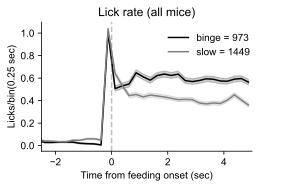

In [5]:
## only take summation of first 2-sec?

def load_lick_event(file_path):
    # dat = load_npy()
    dat = np.load(file_path, allow_pickle=True)
    PETH_lick_binge  = dat.item().get('PETH_lick_binge')
    PETH_lick_slow   = dat.item().get('PETH_lick_slow')
    return PETH_lick_binge,PETH_lick_slow

def lick_df_sns(PETH_lick_binge_concat):
    PETH_lick_binge_concat_sns = PETH_lick_binge_concat.T.reset_index().melt(value_name='Lick',var_name='Time (sec)',id_vars='index')
    PETH_lick_binge_concat_sns = PETH_lick_binge_concat_sns.rename(columns={'index':'Trial'})
    return  PETH_lick_binge_concat_sns

def deco_scale(data,**kws):
    ax = plt.gca()
    yticks = ax.get_yticks()
    yunit = yticks[1]-yticks[0]
    yunit = round(yunit,1)
    # if yunit >0.1:
    #     yunit=0.1 # shrink it?
    ylims = ax.get_ylim()
    y_bottom,y_top = ylims[0], ylims[0]+yunit
    ax.plot([5,5],[y_bottom,y_top],c='k')
    ax.text(5.1,y_bottom+yunit/2,f'{yunit} Hz',va='center',ha='left') # \u03C3 is sigma=sd
    ax.plot([4,5],[y_bottom,y_bottom],c='k')
    ax.text(4.5,y_bottom-0.01,'1 sec',ha='center',va='top')
    # ax.axvline(x=0,ls=':',c='k')
    # ax.set_axis_off()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.set_xlabel('Time from feeding onset (sec)',labelpad=10)
    sns.despine(bottom=True,left=True,ax=ax)
    ax.set_xlim(xmin=-3)

binsize_list = [0.25]
lick_count_binge_concat = []
lick_count_slow_concat = []
time_period_lick_count = 2 # sec

triton_mouse_list = ['BES0421','DSC016028','DSC019409']
triton_dates = ['211006','211007','211008','211009','211011',
                '220126','220127','220128','220129','220131','220201','220202','220203','220204','220207','220208',
                '221102','221103','221104','221105']

plt.figure(figsize=[5,2*len(binsize_list)])

for idx,binsize in enumerate(binsize_list):
    file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
    extension = 'npy'
    os.chdir(file_folder)
    result = sorted(glob.glob('*.{}'.format(extension)))
    result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa data
    result = [r for r in result if 'severe' not in r] # to exclude fasted data
    # mouse_id = 'BES0427'
    mouse_id = ''
    if mouse_id != '':
        result = [r for r in result if mouse_id in r]

    ## remove triton dates
    r_ = []
    for r in result:
        mouse_id_temp = r.split('_')[0]
        if mouse_id_temp in triton_mouse_list:
            date = r.split('_')[1].replace(".","")
            if date not in triton_dates:
                r_.append(r)
        else:
            r_.append(r)
    PETH_lick_binge_concat = pd.DataFrame([],index=np.arange(-5+binsize/2,5+binsize/2,step=binsize))
    PETH_lick_slow_concat  = pd.DataFrame([],index=np.arange(-5+binsize/2,5+binsize/2,step=binsize))

    for r in r_:
        file_path = os.path.join(file_folder,r)
        PETH_lick_binge,PETH_lick_slow = load_lick_event(file_path)
        lick_count_binge = PETH_lick_binge.count(0.25)[0:time_period_lick_count].sum().values
        lick_count_slow  = PETH_lick_slow.count(0.25)[0:time_period_lick_count].sum().values
        PETH_lick_binge_concat = pd.concat([PETH_lick_binge_concat,PETH_lick_binge.count(binsize)],axis=1)
        PETH_lick_slow_concat  = pd.concat([PETH_lick_slow_concat,PETH_lick_slow.count(binsize)],axis=1)
        lick_count_binge_concat.append(lick_count_binge)
        lick_count_slow_concat.append(lick_count_slow)

    PETH_lick_binge_concat.columns = range(PETH_lick_binge_concat.shape[1]) # reset column trial number
    PETH_lick_slow_concat.columns  = range(PETH_lick_slow_concat.shape[1])

    cumulative = False
    if cumulative:
        ## remove all pump events before 0, to make it not confusing (pump event before feeding onset)
        PETH_lick_binge_concat[:0] = 0
        PETH_lick_slow_concat[:0]  = 0
        ## convert df to cummulative values
        PETH_lick_binge_concat = PETH_lick_binge_concat.cumsum(axis=0)
        PETH_lick_slow_concat  = PETH_lick_slow_concat.cumsum(axis=0)

    # subplot_num = int(f'{len(binsize_list)}1{idx+1}')
    # plt.subplot(subplot_num)
    PETH_lick_binge_concat_sns = lick_df_sns(PETH_lick_binge_concat)
    PETH_lick_slow_concat_sns  = lick_df_sns(PETH_lick_slow_concat)

    ## concat 2 df
    PETH_lick_binge_concat_sns['Feeding type'] = 'binge'
    PETH_lick_slow_concat_sns['Feeding type']  = 'slow'
    binge_trial_num = len(PETH_lick_binge_concat_sns['Trial'].unique())
    slow_trial_num  = len(PETH_lick_slow_concat_sns['Trial'].unique())
    PETH_lick_slow_concat_sns['Trial'] += binge_trial_num
    PETH_lick_merge = pd.concat([PETH_lick_binge_concat_sns,PETH_lick_slow_concat_sns],axis=0).reset_index(drop=True)
    g = sns.relplot(data = PETH_lick_merge,x='Time (sec)',y='Lick',hue='Feeding type',errorbar='se',kind='line',
                    palette=color_map_black_grey,height=2.5,aspect=1.5)
    
    # g.map_dataframe(deco_scale)
    sns.despine()
    g.refline(x=0,color='grey',alpha=0.5)
    # plt.ylim(ymax=1.25)
    new_labels = [f'binge = {binge_trial_num}', f'slow = {slow_trial_num}']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    # sns.move_legend(g,loc=[0.025,0.65]) # for individual mouse plotting
    # plt.ylabel(f'Licks')
    plt.xlabel('Time from feeding onset (sec)')
    plt.xlim([-2.5,5])
    # plt.yticks([0,10,20])
    if cumulative:
        sns.move_legend(g,loc=[0.175,0.675],title=None)
        plt.title([f'Cumu. licks (example mouse)' if mouse_id !='' else 'Cumu. licks (all mice)'][0])
        plt.ylabel(f'Licks')
    else:
        sns.move_legend(g,loc=[0.575,0.675],title=None)
        plt.title([f'Licks rate (example mouse)' if mouse_id !='' else 'Lick rate (all mice)'][0])
        plt.ylabel(f'Licks/bin({binsize} sec)')
    if mouse_id!='':
        plot_name = f'1_Lickrate_1mouse'
    else:
        plot_name = f'1_Lickrate_allmice'
    if cumulative:
        plot_name = plot_name+f'_cumulative'
    save_plot_pdf(plot_name)

    # fig_output_folder = '/Users/hunglo/Documents/inscopix_csv/fig_output/'
    # kwargs = {"facecolor":"white","dpi":300,"bbox_inches":"tight"}
    # plt.savefig(f'{fig_output_folder}{plot_name}.pdf',**kwargs)


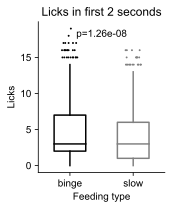

In [6]:
## quantification of licks
# lick_count_binge_concat is obtained from the lick rate plotting code above

lick_count_binge_flat = [item for sublist in lick_count_binge_concat for item in sublist]
lick_count_slow_flat  = [item for sublist in lick_count_slow_concat for item in sublist]

lick_count_df = pd.DataFrame([lick_count_binge_flat,lick_count_slow_flat],index=['binge','slow']).T
lick_count_df = lick_count_df.melt(var_name='Feeding type',value_name='licks')

plt.figure(figsize=[2.5,3])
# sns.violinplot(data=lick_count_df,y='licks',x='feeding type',width=0.5,palette=my_color_map)
flierprops = dict(marker='.',markeredgecolor='k',markersize=2,linestyle='none',alpha=1)
medianprops = dict(color="white")
boxprops= dict(edgecolor="white")
whiskerprops = dict(color="k")

ax=sns.boxplot(data=lick_count_df,y='licks',x='Feeding type',width=0.5,palette=color_map_black_grey,
               flierprops=flierprops, showcaps=False, medianprops = medianprops, boxprops=boxprops,whiskerprops=whiskerprops)
plt.title(f'Licks in first {time_period_lick_count} seconds')
sns.despine()
# plt.yticks([0,5,10,15,20])
# plt.ylim(ymax=22)
plt.tight_layout()

# jitter outliners
for artist in ax.lines:
    if artist.get_linestyle() == "None":
        pos = artist.get_xdata()
        artist.set_xdata(pos + np.random.uniform(-.125, .125, len(pos)))

## now change all lines & fliers to black and grey
box_patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')
    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

plt.ylabel('Licks')
from scipy import stats
_,pval = stats.ttest_ind(lick_count_binge_flat,lick_count_slow_flat)
ax.text(x=0.5,y=0.9,s=f'p={pval:.2e}',ha='center',fontsize=10,transform=ax.transAxes)

# ## get the size of plots, use it 
# fig = plt.gcf()
# size = fig.get_size_inches()*fig.dpi # size in pixels
# print(size)

plot_name = f'1_licks_2second_allmice_{time_period_lick_count}'
save_plot_pdf(plot_name)


<Figure size 360x144 with 0 Axes>

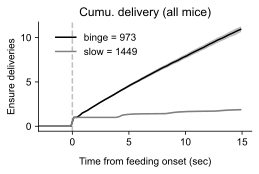

In [7]:
## use the same principle to plot cummulative pump events for slowa and binge eating, set for 10 sec?

def load_peth_pump_event(file_path):
    dat = np.load(file_path, allow_pickle=True)
    PETH_pump_binge  = dat.item().get('PETH_pump_binge')
    PETH_pump_slow   = dat.item().get('PETH_pump_slow')
    return PETH_pump_binge,PETH_pump_slow

def pump_df_sns(PETH_lick_binge_concat):
    PETH_lick_binge_concat_sns = PETH_lick_binge_concat.T.reset_index().melt(value_name='Pump delivery',var_name='Time (sec)',id_vars='index')
    PETH_lick_binge_concat_sns = PETH_lick_binge_concat_sns.rename(columns={'index':'Trial'})
    return  PETH_lick_binge_concat_sns

def deco_scale(data,**kws):
    ax = plt.gca()
    ax.set_yticks([0,5,10])
    ax.set_xlabel('Time from feeding onset (sec)',labelpad=10)
    sns.despine()
    ax.set_xlim(xmin=-3)

binsize_list = [1]
## don't need to binge this one? just directly make it to cumulative values?

lick_count_binge_concat = []
lick_count_slow_concat = []

triton_mouse_list = ['BES0421','DSC016028','DSC019409']
triton_dates = ['211006','211007','211008','211009','211011',
                '220126','220127','220128','220129','220131','220201','220202','220203','220204','220207','220208',
                '221102','221103','221104','221105']

plt.figure(figsize=[5,2*len(binsize_list)])


file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
extension = 'npy'
os.chdir(file_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa data
result = [r for r in result if 'severe' not in r] # to exclude fasted data
# mouse_id = 'BES0427'
mouse_id = ''
if mouse_id != '':
    result = [r for r in result if mouse_id in r]

## remove triton dates
r_ = []
for r in result:
    mouse_id_temp = r.split('_')[0]
    if mouse_id_temp in triton_mouse_list:
        date = r.split('_')[1].replace(".","")
        if date not in triton_dates:
            r_.append(r)
    else:
        r_.append(r)

## note the t scale for pump events are -5 to +10, not -5 to +5 as it is in lick events
PETH_pump_binge_concat = pd.DataFrame([],index=np.arange(-5+binsize/2,15+binsize/2,step=binsize))
PETH_pump_slow_concat  = pd.DataFrame([],index=np.arange(-5+binsize/2,15+binsize/2,step=binsize))

for r in r_:
    file_path = os.path.join(file_folder,r)
    PETH_pump_binge,PETH_pump_slow = load_peth_pump_event(file_path)
    PETH_pump_binge_concat = pd.concat([PETH_pump_binge_concat,PETH_pump_binge.count(binsize)],axis=1)
    PETH_pump_slow_concat  = pd.concat([PETH_pump_slow_concat,PETH_pump_slow.count(binsize)],axis=1)


PETH_pump_binge_concat.columns = range(PETH_pump_binge_concat.shape[1]) # reset column trial number
PETH_pump_slow_concat.columns  = range(PETH_pump_slow_concat.shape[1])

## remove all pump events before 0, to make it not confusing (pump event before feeding onset)
PETH_pump_binge_concat[:0] = 0
PETH_pump_slow_concat[:0]  = 0

## convert df to cummulative values
PETH_pump_binge_concat = PETH_pump_binge_concat.cumsum(axis=0)
PETH_pump_slow_concat  = PETH_pump_slow_concat.cumsum(axis=0)

# subplot_num = int(f'{len(binsize_list)}1{idx+1}')
# plt.subplot(subplot_num)
PETH_pump_binge_concat_sns = pump_df_sns(PETH_pump_binge_concat)
PETH_pump_slow_concat_sns  = pump_df_sns(PETH_pump_slow_concat)

## concat 2 df
PETH_pump_binge_concat_sns['Feeding type'] = 'binge'
PETH_pump_slow_concat_sns['Feeding type']  = 'slow'
binge_trial_num = len(PETH_pump_binge_concat_sns['Trial'].unique())
slow_trial_num  = len(PETH_pump_slow_concat_sns['Trial'].unique())
PETH_pump_slow_concat_sns['Trial'] += binge_trial_num
PETH_pump_merge = pd.concat([PETH_pump_binge_concat_sns,PETH_pump_slow_concat_sns],axis=0).reset_index(drop=True)
g = sns.relplot(data = PETH_pump_merge,x='Time (sec)',y='Pump delivery',hue='Feeding type',errorbar='ci',kind='line',palette=color_map_black_grey,height=2.5,aspect=1.5).set(title=[f'Cumu. delivery (example mouse)' if mouse_id !='' else 'Cumu. delivery (all mice)'][0])
g.map_dataframe(deco_scale)
g.refline(x=0,color='grey',alpha=0.5)
# plt.ylim(ymax=1.6)
new_labels = [f'binge = {binge_trial_num}', f'slow = {slow_trial_num}']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
# sns.move_legend(g, loc=2)
# sns.move_legend(g,loc=[0.025,0.65]) # for individual mouse plotting
sns.move_legend(g,loc=[0.2,0.65],title=None)
# sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
plt.ylabel('Ensure deliveries')

if mouse_id!='':
    plot_name = '1_cum_pump_1mouse'
else:
    plot_name = '1_cum_pump_allmice'

save_plot_pdf(plot_name)

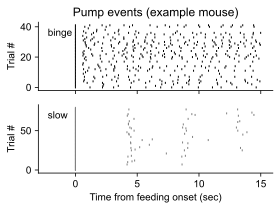

In [8]:
## plot pump events example

file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
extension = 'npy'
os.chdir(file_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa data
result = [r for r in result if 'severe' not in r] # to exclude fasted data
mouse_id = 'BES0427'
# mouse_id = ''
if mouse_id != '':
    result = [r for r in result if mouse_id in r]
## remove triton dates
r_ = []
for r in result:
    mouse_id_temp = r.split('_')[0]
    if mouse_id_temp in triton_mouse_list:
        date = r.split('_')[1].replace(".","")
        if date not in triton_dates:
            r_.append(r)
    else:
        r_.append(r)

## note, BES0427 is not a triton mouse, so we don't need to remove triton dates

fig, axes = plt.subplots(nrows=2,sharex=True,figsize=[4,3],sharey=False)
y_offset_binge = 0
y_offset_slow = 0
num_trials_plot = 80

for r in r_:
    file_path = os.path.join(file_folder,r)
    # PETH_lick_binge,PETH_lick_slow = load_lick_event(file_path)
    PETH_pump_binge,PETH_pump_slow = load_peth_pump_event(file_path)

    for key in PETH_pump_binge.keys():
        if y_offset_binge > num_trials_plot :
            continue
        len_pump_binge = len(PETH_pump_binge[key].as_units('s').index)
        axes[0].plot(PETH_pump_binge[key].as_units('s').index,np.ones(len_pump_binge)*y_offset_binge,c='black',ls='',marker='|',markersize=2)
        y_offset_binge+=1

    for key in PETH_pump_slow.keys():
        if y_offset_slow > num_trials_plot :
            continue
        len_pump_slow = len(PETH_pump_slow[key].as_units('s').index)
        # # ts = PETH_pump_slow[key].as_units('s').index
        # # diff = np.diff(np.array(ts))
        # # if len(diff)==0: # no pump event
        # #     y_offset_slow+=1
        # #     continue
        # # else:
        #     if diff[0] <3:
        #         continue
        if True:
            # else:
                axes[1].plot(PETH_pump_slow[key].as_units('s').index,np.ones(len_pump_slow)*y_offset_slow,c='grey',ls='',marker='|',markersize=2)
                y_offset_slow+=1
axes[0].text(0.04,0.8,s='binge',ha='left',transform=axes[0].transAxes)
axes[1].text(0.04,0.8,s='slow', ha='left',transform=axes[1].transAxes)

axes[0].set_ylabel('Trial #')
axes[1].set_ylabel('Trial #') # align y labels
axes[1].set_xlabel('Time from feeding onset (sec)')
axes[1].set_xlim(xmin=-3)
# axes[0].set_yticks([0,40])
sns.despine()
axes[0].set_title('Pump events (example mouse)')
plt.tight_layout()
plot_name = '1x_pump_events_example'
save_plot_pdf(plot_name)

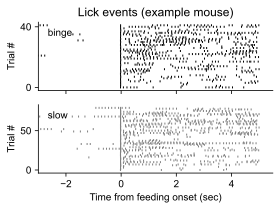

In [9]:
## licks events for example mouse
file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
extension = 'npy'
os.chdir(file_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa data
result = [r for r in result if 'severe' not in r] # to exclude fasted data
mouse_id = 'BES0427'
# mouse_id = ''
if mouse_id != '':
    result = [r for r in result if mouse_id in r]

## note, BES0427 is not a triton mouse, so we don't need to remove triton dates

fig, axes = plt.subplots(nrows=2,sharex=True,figsize=[4,3],sharey=False)
y_offset_binge = 0
y_offset_slow = 0
num_trials_plot = 80

for r in r_:
    file_path = os.path.join(file_folder,r)
    PETH_lick_binge,PETH_lick_slow = load_lick_event(file_path)
    for key in PETH_lick_binge.keys():
        if y_offset_binge > num_trials_plot :
            continue
        len_lick_binge = len(PETH_lick_binge[key].as_units('s').index)
        axes[0].plot(PETH_lick_binge[key].as_units('s').index,np.ones(len_lick_binge)*y_offset_binge,c='black',ls='',marker='|',markersize=2)
        y_offset_binge+=1
    for key in PETH_lick_slow.keys():
        if y_offset_slow > num_trials_plot :
            continue
        len_lick_slow = len(PETH_lick_slow[key].as_units('s').index)
        axes[1].plot(PETH_lick_slow[key].as_units('s').index,np.ones(len_lick_slow)*y_offset_slow,c='grey',ls='',marker='|',markersize=2)
        y_offset_slow+=1
axes[0].text(0.04,0.8,s='binge',ha='left',transform=axes[0].transAxes)
axes[1].text(0.04,0.8,s='slow', ha='left',transform=axes[1].transAxes)

axes[0].set_ylabel('Trial #')
axes[1].set_ylabel('Trial #') # align y labels
axes[1].set_xlabel('Time from feeding onset (sec)')
axes[1].set_xlim(xmin=-3)
axes[0].set_yticks([0,40])
sns.despine()
axes[0].set_title('Lick events (example mouse)')
plt.tight_layout()
plot_name = '1_lick_events_example'
save_plot_pdf(plot_name)

In [46]:
## check npy files
file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
extension = 'npy'
os.chdir(file_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa data
# result = [r for r in result if 'DSC018623' in r]
result = [r for r in result if 'BES0224' in r]
# result = [r for r in result if '20.08.18' in r]

# print(result)
file_path = os.path.join(file_folder,result[0]) # 623: 4,6,9 ok
print(file_path)
dat = np.load(file_path, allow_pickle=True)
print(dat.item().keys())

def load_npy(file_path):
    dat = np.load(file_path, allow_pickle=True)
    PETH_binge_on   = dict2np(dat.item().get('PETH_binge_on'))
    PETH_binge_off  = dict2np(dat.item().get('PETH_binge_off'))
    PETH_slow_milk  = dict2np(dat.item().get('PETH_slow_milk'))
    PETH_slow_water = dict2np(dat.item().get('PETH_slow_water'))
    PETH_lick_binge = dat.item().get('PETH_lick_binge')
    PETH_lick_slow  = dat.item().get('PETH_lick_slow')
    PETH_pump_binge = dat.item().get('PETH_pump_binge')
    PETH_pump_slow  = dat.item().get('PETH_pump_slow')
    return PETH_binge_on, PETH_binge_off, PETH_slow_milk, PETH_slow_water, PETH_lick_binge, PETH_lick_slow, PETH_pump_binge, PETH_pump_slow

def dict2np(PETH):

    keys = list(PETH.keys())

    if len(keys) == 0:
        return None
    else:
        dat_temp = PETH.get(keys[0])
        PETH_new = np.zeros((len(keys),dat_temp.shape[0],dat_temp.shape[1]))
        for idx,cell in enumerate(keys):
            PETH_new[idx,:,:] = PETH[cell]
        return PETH_new

PETH_binge_on, PETH_binge_off, PETH_slow_milk, PETH_slow_water, PETH_lick_binge, PETH_lick_slow, PETH_pump_binge, PETH_pump_slow = load_npy(file_path=file_path)

# print(PETH_binge_on)

## now perform auROC here?

# for i in range(5):
#     traces = PETH_binge_on[i]
#     # print(PETH_binge_on.get(key).mean(axis=0))
#     plt.plot(traces.mean(axis=0)+traces.shape[0],color='k')
#     # plt.show()
#     # plt.imshow(PETH_binge_on.get(key), aspect='auto')
#     ca2_plot(df=pd.DataFrame(traces).T,scale=1,cell_idx=None,ls='--')
#     plt.axvline(x=50,color='k',ls=':',lw=1)
#     sns.despine()
#     plt.show()

# PETH_lick_slow[0]

# plt.figure(figsize=[5,4])
# ax1 = plt.subplot(311)
# plt.title(f'{mouse_id} {date} lick events')
# plt.plot(PETH_lick_binge.count(0.25, time_units = 's').mean(1),label='binge')
# plt.plot(PETH_lick_slow.count(0.25, time_units = 's').mean(1),label='slow')
# plt.legend()
# # plt.xlim(xmin=-2)

# plt.subplot(312,sharex=ax1)
# for stim_index in PETH_lick_binge.keys():
#     plt.plot(PETH_lick_binge[stim_index].as_units('s').fillna(stim_index), '|')
# plt.legend(['binge onset'],loc=2)
# plt.subplot(313,sharex=ax1)
# for stim_index in PETH_lick_slow.keys():
#     plt.plot(PETH_lick_slow[stim_index].as_units('s').fillna(stim_index), '|')
# plt.legend(['slow feeding onset'],loc=2)
# plt.xlabel("Time from feeding onset (s)")
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=[5,4])
# ax1 = plt.subplot(311)
# plt.title(f'{mouse_id} {date} pump events')
# plt.plot(PETH_pump_binge.count(0.1, time_units = 's').mean(1),label='binge')
# plt.plot(PETH_pump_slow.count(0.1, time_units = 's').mean(1),label='slow')
# plt.legend()
# # plt.xlim(xmin=-2)

# plt.subplot(312, sharex=ax1)
# for stim_index in PETH_pump_binge.keys():
#     plt.plot(PETH_pump_binge[stim_index].as_units('s').fillna(stim_index), '|')
# plt.legend(['binge onset'],loc=2)
# plt.subplot(313, sharex=ax1)
# for stim_index in PETH_pump_slow.keys():
#     plt.plot(PETH_pump_slow[stim_index].as_units('s').fillna(stim_index), '|')
# plt.legend(['slow feeding onset'],loc=2)
# plt.xlabel("Time from feeding onset (s)")
# plt.tight_layout()
# plt.show()


# PETH_lick_binge[[0,1]]

/Users/hunglo/Documents/inscopix_csv/processed_npy/BES0224_20.08.18_CaMK2_strawberry_water_mild.npy
dict_keys(['PETH_binge_on', 'PETH_binge_off', 'PETH_slow_milk', 'PETH_slow_water', 'PETH_slow_milk_onset', 'PETH_slow_water_onset', 'Binge_epoch', 'slow_feeding_onset', 'PETH_lick_slow', 'PETH_lick_binge', 'PETH_lick_slow_water', 'PETH_pump_slow', 'PETH_pump_binge', 'PETH_pump_slow_water', 'mouse_name', 'mouse_id', 'cell_type', 'date_exp', 'pump_solution', 'dt', 'food_deprivation_level'])


In [11]:
## function for calculate auroc for slow feeding events

def cal_auroc(PETH, baseline_window=1,steps=20):
  """
  PETH: 3D np array of neuronal matrix, ordered with neurons, trials, timestamps
  baseline_window: * sec before pump delivery, default is 1 sec

  """
  from sklearn.metrics import auc

  auc_total_all_cell       = np.zeros((PETH.shape[0],PETH.shape[2]))
  frate = 10 # all 10 Hz

  data = PETH
  for idx in range(data.shape[0]):
        if idx%50==0:
          print(f'now at neuron: {idx}')
        
        baseline = data[idx,:,50-baseline_window*frate:50].flatten()
        auc_total = []
        for i in range(data.shape[2]):
          stimulus = data[idx,:,i]
          pool = [*baseline, *stimulus]
          steps = steps
          criteria = [min(pool) + (j*(max(pool)-min(pool))/steps) for j in range(steps)]
          criteria[0] = criteria[0] - 1e-12 # modify the min value to slighter lesser value, so baseline/stimulus will be larger than the min of criteria
          pbase = []
          pstim = []
          # Calculate P(above threshold) for each cutoff
          for cri in criteria:
            pbase.append(sum(baseline > cri)/len(baseline))
            pstim.append(sum(stimulus > cri)/len(stimulus))
          auc_ = auc(x = pbase, y = pstim)
          auc_total.append(auc_)
        auc_total_all_cell[idx,:] = auc_total

  return auc_total_all_cell

# auroc = cal_auroc(PETH_slow_milk, baseline_window=5)
# auroc

## make a classification function here based on auROC
def checkConsecutive(l,n=3):
    n = n-1 # diff will be one less than all elements in the list
    return (sum(np.diff(sorted(l)) == 1) >= n) 

def cell_class(auroc,window=2,threshold_sd=3.5):
   idx_positive = []
   idx_negative = []
   frate = 10
   for idx in range(auroc.shape[0]):
    threshold_high = np.mean(auroc[idx,40:50]) + np.std(auroc[idx,40:50])*threshold_sd
    auroc_temp = auroc[idx].copy()
    j_temp = []
    for j in range(50,50+window*frate):  # Only look at first 2 sec after delivery (the window size)
        if auroc_temp[j] > threshold_high:
           j_temp.append(j)
    if j_temp !=[]:
        if checkConsecutive(j_temp,n=3) == True:
           idx_positive.append(idx)
      # print('# {} is responding to milk'.format(idx))
   for idx in range(auroc.shape[0]):
    threshold_high = np.mean(auroc[idx,40:50]) - np.std(auroc[idx,40:50])*threshold_sd
    auroc_temp = auroc[idx].copy()
    j_temp = []
    for j in range(50,50+window*frate):  # Only look at first 2 sec after delivery (the window size)
        if auroc_temp[j] < threshold_high:
           j_temp.append(j)
    if j_temp !=[]:
        if checkConsecutive(j_temp,n=3) == True:
           idx_negative.append(idx)
      # print('# {} is responding to milk'.format(idx))
   ## make idx for non-responding neurons
   cellnum = auroc.shape[0]
   idx_non = []
   idx_non = [i for i in range(cellnum) if i not in idx_positive and i not in idx_negative]
   return idx_positive, idx_negative, idx_non


In [12]:
## function for calculate cohen's d for binge feeding events

def cal_cohensd(mouse_id,window_size=None,processed_npy_path=None):
    print(mouse_id)
    if processed_npy_path is None:
        processed_npy_path = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
    extension = 'npy'
    os.chdir(file_folder)
    result = sorted(glob.glob('*.{}'.format(extension)))
    result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa mice
    result = [r for r in result if mouse_id in r]

    if window_size is None:
        window_size=[1,4] # from +-1 sec to onset, to +-4 sec to onset

    estimation_list = []
    date_list = []
    triton_list = []
    fasting_list = []
    milk_consumption_list = []
    window_size_list_inloop = []

    triton_mouse_list = ['BES0421','DSC016028','DSC019409']

    if mouse_id in triton_mouse_list:
        triton_dates = ['211006','211007','211008','211009','211011',
                        '220126','220127','220128','220129','220131','220201','220202','220203','220204','220207','220208',
                        '221102','221103','221104','221105']
    else:
        triton_dates = []

    for i in result[:]:
        datenodot = i.split('_')[1].replace('.','')
        print(datenodot)

        file_path = os.path.join(file_folder,i)
        PETH_binge_on, _,_,_,_,_,_,_ = load_npy(file_path=file_path) # note date will be print from here
        if PETH_binge_on is None:
            print('no binges, skip')
            continue
        else:
            print(PETH_binge_on.shape)
            if PETH_binge_on.shape[0]<3: # too few cells
                print('too few cells, skip')
                continue
            else:
                date_list.append(datenodot)
                if datenodot in triton_dates:
                    triton_list.append(True)
                else:
                    triton_list.append(False)
                if 'severe' in i:
                    fasting_list.append(True)
                else:
                    fasting_list.append(False)

                ## convert np array to pd.DataFrame
                df_binge_auc = pd.DataFrame([np.trapz(PETH_binge_on[:,:,50-window_size[1]*10:50-window_size[0]*10].mean(axis=(1)),dx=0.1),
                                             np.trapz(PETH_binge_on[:,:,50+window_size[0]*10:50+window_size[1]*10].mean(axis=(1)),dx=0.1),])
                df_binge_auc = df_binge_auc.T
                                            #  columns=['Pre-binge-on','Post-binge-on'])
                df_binge_auc.rename(columns={0:'Pre-binge-on',1:'Post-binge-on'},inplace=True)
                df_binge_auc = df_binge_auc.reset_index()
                df_binge_auc.rename(columns={'index':'ID'},inplace=True)
                df_binge_auc

                ## Save estimation object in dict
                estimation_dict = {}
                two_groups_paired = dabest.load(df_binge_auc, idx=("Pre-binge-on","Post-binge-on"),paired=True, id_col="ID")
                estimate = two_groups_paired.cohens_d.results

                estimation_dict[i] = estimate
                estimation_list.append(estimate['difference'].to_numpy()[0])
                # print(f'>AUC cohens_d: {estimation_list[-1]:.2f}')
                Phenosys_folder = '/Users/hunglo/Documents/inscopix_csv/Phenosys_csv/'
                extension = 'csv'
                os.chdir(Phenosys_folder)
                result_pheno = sorted(glob.glob('*.{}'.format(extension)))
                result_pheno = [r for r in result_pheno if mouse_id in r]
                result_pheno = [r for r in result_pheno if i.split('_')[1] in r]
                file_path_pheno = os.path.join(Phenosys_folder,result_pheno[0])
                L1,P1,P2,PAll = binge.load_phenosys(file_path_pheno)
                milk_consumption = len(PAll)
                milk_consumption_list.append(milk_consumption)
                window_size_str = f'{window_size[0]}_{window_size[1]}'
                window_size_list_inloop.append(window_size_str)           

    df_estimate = pd.DataFrame([date_list,estimation_list]).T
    df_estimate.rename(columns={0:'date',1:'cohens_d'}, inplace=True)
    df_estimate['cohens_d'] = df_estimate['cohens_d'].astype('float')
    df_estimate['mouse_id'] = mouse_id
    df_estimate['anosmic'] = triton_list
    df_estimate['fasted'] = fasting_list
    df_estimate['milk_consumption'] = milk_consumption_list
    df_estimate['window_size'] = window_size_list_inloop

    return df_estimate


In [42]:
## calculate cohen's d based on groups
## already calculated so skip for now, you can find results in 'processed_csv'

if True:
    df_estimate_concat = pd.DataFrame([])

    camk2_mouse_id_list = ['BES0224','BES0225','BES0233','BES0421','BES0424','BES0427','DSC016028','DSC019409']
    gc_mouse_id_list = ['DSC018623','DSC018624','DSC017911']
    s2_mouse_id_list = ['DSC017909','DSC017914']
    pv_mouse_id_list = ['DSC012019','DSC012487','DSC016006']
    sst_mouse_id_list = ['DSC012972','DSC013919','DSC014459' ]

    window_size_list = [[0,4],
                        [1,4],
                        [2,4],
                        [0,3],
                        [1,3],
                        [0,2],
                        [0,1]]

    Celltype = 's2'
    # Celltype = 'gc'
    # Celltype = 'apc_camk2'
    # Celltype = 'apc_sst'
    # Celltype = 'apc_pv'

    df_estimate_concat = pd.DataFrame([])

    # for mouse_id in camk2_mouse_id_list:
    # for mouse_id in gc_mouse_id_list:
    for mouse_id in s2_mouse_id_list:
    # for mouse_id in pv_mouse_id_list:
    # for mouse_id in sst_mouse_id_list:
        print(mouse_id)
        for window_size in window_size_list:
            df_estimate = cal_cohensd(mouse_id=mouse_id,window_size=window_size)
            df_estimate['Celltype'] = Celltype
            df_estimate_concat = pd.concat([df_estimate_concat,df_estimate])

    df_estimate_concat.to_csv(f'/Users/hunglo/Documents/inscopix_csv/processed_csv/{Celltype}_cohensd_window.csv',index=False)
    print(f'\nDone for {mouse_id}')

print(f'Done for {Celltype}')


DSC017909
DSC017909
220815
(83, 12, 100)
220816
(92, 8, 100)
220817
(89, 2, 100)
220818
(93, 4, 100)
220819
(93, 2, 100)
220822
(157, 3, 100)
220823
(116, 4, 100)
220824
(116, 3, 100)
220825
(106, 4, 100)
220826
(130, 4, 100)
220829
(131, 3, 100)
220830
(126, 1, 100)
220831
(82, 3, 100)
220905
(91, 2, 100)
220907
(96, 3, 100)
220908
(80, 2, 100)
220909
(67, 5, 100)
220912
(106, 3, 100)
220914
(72, 4, 100)
220915
(58, 2, 100)
220917
(66, 2, 100)
220919
(75, 3, 100)
220920
(64, 5, 100)
DSC017909
220815
(83, 12, 100)
220816
(92, 8, 100)
220817
(89, 2, 100)
220818
(93, 4, 100)
220819
(93, 2, 100)
220822
(157, 3, 100)
220823
(116, 4, 100)
220824
(116, 3, 100)
220825
(106, 4, 100)
220826
(130, 4, 100)
220829
(131, 3, 100)
220830
(126, 1, 100)
220831
(82, 3, 100)
220905
(91, 2, 100)
220907
(96, 3, 100)
220908
(80, 2, 100)
220909
(67, 5, 100)
220912
(106, 3, 100)
220914
(72, 4, 100)
220915
(58, 2, 100)
220917
(66, 2, 100)
220919
(75, 3, 100)
220920
(64, 5, 100)
DSC017909
220815
(83, 12, 100)
2

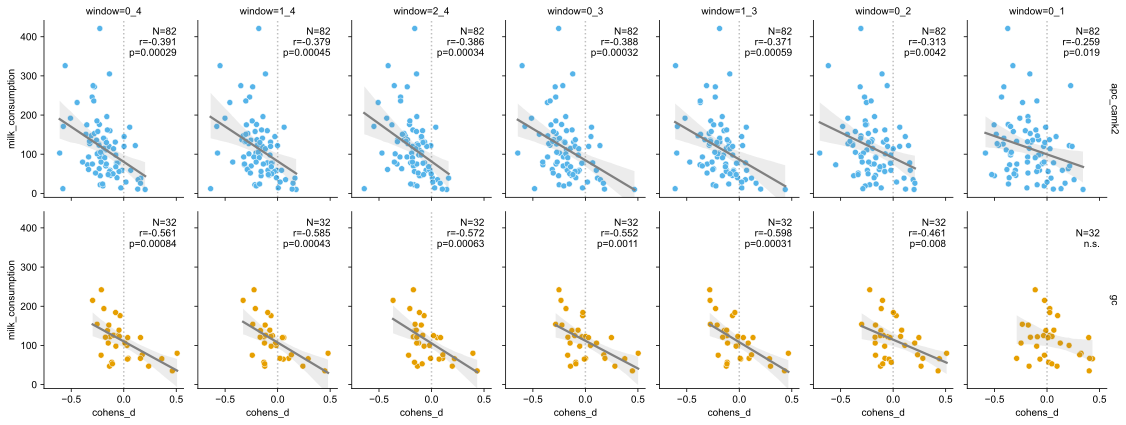

In [45]:
## concatenate all saved csv together

file_list = ['apc_camk2_cohensd_window.csv',
             'apc_pv_cohensd_window.csv',
             'apc_sst_cohensd_window.csv',
             'gc_cohensd_window.csv',
             's2_cohensd_window.csv']

df_estimate_concat = pd.DataFrame([])

## concatenate files

for file in file_list:
    file_path = os.path.join('/Users/hunglo/Documents/inscopix_csv/processed_csv/',file)
    df_estimate = pd.read_csv(file_path)
    df_estimate_concat = pd.concat([df_estimate_concat,df_estimate])


import scipy as sp
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['cohens_d'], data['milk_consumption'])
    n = len(data)
    ax = plt.gca()
    ax.axvline(x=0,ls=":",c='k',alpha=0.25)
    if p < 0.05:
        ax.text(.95, .8, f'N={n}\nr={r:.3f}\np={p:.2g}',ha='right',
                transform=ax.transAxes)
        sns.regplot(data=data,x='cohens_d',y='milk_consumption',ax=ax,scatter=False,color='grey')
        # ax.set_axis(off)
        # x_axis = ax.axes.get_xaxis()
        # x_label = x_axis.get_label()
        # x_label.set_visible(False)
    else:
        ax.text(.95, .8, f'N={n}\nn.s.',transform=ax.transAxes,ha='right')
        sns.regplot(data=data,x='cohens_d',y='milk_consumption',ax=ax,scatter=False,color='grey',line_kws={"linestyle":""})
        # x_axis = ax.axes.get_xaxis()
        # x_label = x_axis.get_label()
        # x_label.set_visible(False)
    ylims = ax.get_ylim()
    if ylims[0]<-10:
        ax.set_ylim(ymin=-10) # to prevent large negative scale

## filter data, exclude fasted days and anosmic days

data = df_estimate_concat[df_estimate_concat['fasted'] == False]
# data = df_estimate_concat[df_estimate_concat['fasted'] == True]
data = data[data['anosmic']==False]
cell_list = ['apc_camk2','gc']
data = data[data['Celltype'].isin(cell_list)]
# data = data[data['window_size'].isin(['0_4','1_4','2_4','0_3','1_3'])]
# data = data[data['window_size'].isin(['0_4'])]

g = sns.FacetGrid(data=data,row='Celltype',col='window_size',margin_titles=True,hue='Celltype', sharex=True, sharey=True,palette=my_color_map,height=3,aspect=0.75,
                  row_order=cell_list,
                  hue_order=cell_list)
# g = sns.lmplot(data=data,x='cohens_d',y='milk_consumption',col='window_size',height=4,aspect=0.75,row='Celltype', sharex=False, sharey=False,hue='Celltype')
g.map_dataframe(sns.scatterplot, x='cohens_d',y='milk_consumption')
g.map_dataframe(annotate)
g.set_titles(col_template="window={col_name}", row_template="{row_name}")
g.fig.subplots_adjust(top=.9)
plt.tight_layout()
plot_name = '5_cohensd_milkconsumption_all_data'
save_plot_pdf(plot_name)


(82, 8)
(3906, 100)
(3906, 100)
(3906, 100)
(3906, 100)
(3906, 100)
milk pos: 11.24%
water pos: 13.67%
both pos: 2.12%
milk neg: 31.64%
milk non: 56.43%


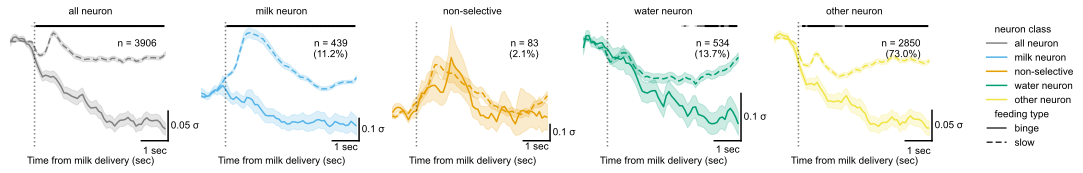

In [79]:
## functions for behavior clusters

def select_sessions(df_estimate_concat, Celltype='apc_camk2', fasted = False, anosmic = False, window_size = '0_4'):
    data = df_estimate_concat[df_estimate_concat['fasted'] == fasted]
    data = data[data['anosmic']==anosmic]
    data = data[data['window_size']==window_size]
    data = data[data['Celltype']==Celltype]
    print(data.shape)

    ## separate data by behavior ranking (%) & by absolute milk consumption values
    data['milk_rank_pct'] = data['milk_consumption'].rank(pct=True)
    data['tertile']       = pd.qcut(data['milk_rank_pct'],   q = 3,    labels=['bottom','middle','top'])
    data['quartile']      = pd.qcut(data['milk_rank_pct'],   q = 4,    labels=['bottom','l-middle','h-middle','top'])
    data['tertile_abs']   = pd.cut(data['milk_consumption'], bins = 3, labels=['bottom','middle','top'])
    data['quartile_abs']  = pd.cut(data['milk_consumption'], bins = 4, labels=['bottom','l-middle','h-middle','top'])

    cohensd_table = data.copy()

    return cohensd_table

def get_npy_path(mouse_id,date):
    file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
    extension = 'npy'
    os.chdir(file_folder)
    result = sorted(glob.glob('*.{}'.format(extension)))
    result = [r for r in result if mouse_id in r]
    if '.' in date:
        datewithdot = date
    else:
        datewithdot = f'{date[0:2]}.{date[2:4]}.{date[4:6]}'
    result = [r for r in result if datewithdot in r]
    # print(result)
    file_path = os.path.join(file_folder,result[0])
    return file_path

def concat_PETH_binge(select_data,mouse_id_list):
    PETH_binge_on_concat = np.zeros([1,100])
    # print(PETH_binge_on_concat.shape)
    for mouse_id in mouse_id_list:
        # print(mouse_id)
        date_list = select_data[select_data['mouse_id']==mouse_id]['date'].values.astype('str')
        for date in date_list:
            # print(f'>{date}')
            PETH_binge_on,_,_,_,_,_,_,_ = load_npy(get_npy_path(mouse_id,date))
            PETH_avg = np.mean(PETH_binge_on,axis=1) # trial average
            # print(PETH_avg.shape[0])
            PETH_binge_on_concat = np.vstack([PETH_binge_on_concat,PETH_avg])
    # print(PETH_binge_on_concat.shape)
    PETH_binge_on_concat = PETH_binge_on_concat[~np.all(PETH_binge_on_concat == 0, axis=1)] # remove first row
    # print(PETH_binge_on_concat.shape)
    return PETH_binge_on_concat

def np2df_long(PETH_binge_on_concat,q=None):
    df_ = pd.DataFrame(PETH_binge_on_concat)
    df_long = pd.melt(df_.reset_index(),id_vars='index',value_name='zs-dff',var_name='Time (sec)')
    df_long['Time (sec)']=(df_long['Time (sec)'].values/10)-5
    df_long['quantile'] = q
    return df_long

## load PETH binge based on their given quantiles

def load_PETH_binge_quantile(data, quantile = 'tertile'):
    quantile_list = data[quantile].unique().to_list()
    # print(quantile_list)
    df_PETH_binge_on_concat_quantile = pd.DataFrame([])
    for q in quantile_list:
        select_data = data[data[quantile]==q]
        mouse_id_list = sorted(select_data['mouse_id'].unique())
        PETH_binge_on_concat = concat_PETH_binge(select_data,mouse_id_list)
        df_PETH_binge_on_concat = np2df_long(PETH_binge_on_concat,q=q)
        df_PETH_binge_on_concat_quantile = pd.concat([df_PETH_binge_on_concat_quantile,df_PETH_binge_on_concat])
        df_PETH_binge_on_concat_quantile = df_PETH_binge_on_concat_quantile.reset_index(drop=True)
    return df_PETH_binge_on_concat_quantile


def quantile_traces(cohensd_table, Celltype, quantile='tertile'):
    if quantile == 'quartile':
        hue_order = ['top','h-middle','l-middle','bottom']
    elif quantile == 'tertile':
        hue_order = ['top','middle','bottom']
    df_PETH_binge_on_concat_quantile = load_PETH_binge_quantile(cohensd_table, quantile = quantile)

    fig,ax = plt.subplots(figsize=[4,3])
    sns.lineplot(data=df_PETH_binge_on_concat_quantile,x='Time (sec)',y='zs-dff',hue='quantile',errorbar='se',palette=sns.color_palette("hls", len(hue_order)),hue_order=hue_order,ax=ax)

    ax.axvline(x=0,ls=':',c='k')
    sns.despine(left=True,bottom=True)
    sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1),frameon=False,title=quantile)

    ax.set_xlim(xmin=-1,xmax=4.1)
    yticks = ax.get_yticks()
    yunit = yticks[1]-yticks[0]
    yunit = round(yunit,3)
    ylims = ax.get_ylim()
    y_bottom,y_top = ylims[0], ylims[0]+yunit
    ax.plot([4,4],[y_bottom,y_top],c='k')
    ax.text(4.1,y_bottom+yunit/2,f'{yunit} \u03C3',va='center',ha='left') # \u03C3 is sigma=sd
    ax.plot([3,4],[y_bottom,y_bottom],c='k')
    ax.text(3.5,y_bottom-0.01,'1 sec',ha='center',va='top')

    ax.set_title(f'Behavioral clusters: {Celltype}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.set_xlabel('Time from binge feeding onset (sec)',labelpad=10)
    # plt.tight_layout()

def generate_cellclass_df(Celltype,quantile,q='top'):
    celltype_dict = {"apc_camk2":"CaMK2",
                 "apc_pv":"PV",
                 "apc_sst":"SST",
                 "gc":"GC",
                 "s2":"S2"}
    file_folder = '/Users/hunglo/Documents/inscopix_csv/auroc_npy/'
    extension = 'npy'
    os.chdir(file_folder)
    result = sorted(glob.glob('*.{}'.format(extension)))
    result = [r for r in result if 'SNA' not in r] # exclude dopa & sero data
    result = [ r for r in result if 'strawberry' in r or 'chocolate' in r or 'vanilla' in r]
    select_celltype = celltype_dict[Celltype]
    result = [ r for r in result if select_celltype in r]

    auroc_slow_milk_concat = np.zeros([1,100])
    auroc_slow_water_concat = np.zeros([1,100])
    PETH_slow_milk_concat  = np.zeros([1,100])
    PETH_slow_water_concat  = np.zeros([1,100])
    PETH_binge_on_concat   = np.zeros([1,100])

    for r in result:
        mouse_id = r.split('_')[1]
        date = r.split('_')[2]
        if not isin_tertile(cohensd_table,mouse_id,date,quantile=quantile,q=q): ## check if this recording is in a gvien tertile of drinking events
            continue
        ## find corresponding water PETH
        file_folder = '/Users/hunglo/Documents/inscopix_csv/auroc_npy/'
        extension = 'npy'
        os.chdir(file_folder)
        result_water = sorted(glob.glob('*.{}'.format(extension)))
        result_water = [rw for rw in result_water if mouse_id in rw and date in rw]
        result_water = [rw for rw in result_water if 'water' in rw]
        if len(result_water) ==0: # if there is no correponding file
            # print('no water auroc')
            continue
        # print(result_water)
        flavor = r.split('_')[4].split('.')[0]
        # print(flavor)

        file_path = os.path.join(file_folder,r)
        file_path_water = os.path.join(file_folder,result_water[0])

        # only load auroc & dff if there are both slow and binge eatings
        dff_path = get_npy_path(mouse_id,date)
        PETH_binge_on, PETH_binge_off, PETH_slow_milk, PETH_slow_water, PETH_lick_binge, PETH_lick_slow, PETH_pump_binge, PETH_pump_slow = load_npy(dff_path)
        flavor1 = dff_path.split('/')[-1].split('_')[3]
        flavor2 = dff_path.split('/')[-1].split('_')[4]
        PETH_avg = np.array([])
        PETH_avg_w = np.array([])
        PETH_avg_binge = np.array([])

        # if PETH_binge_on is not None and (PETH_slow_milk is not None or PETH_slow_water is not None):
        load_auroc = False
        if flavor == flavor1:
            if PETH_binge_on is not None:
                PETH_avg = np.mean(PETH_slow_milk,axis=1) # trial average slow
                PETH_avg_w = np.mean(PETH_slow_water,axis=1) # trial average water
                PETH_avg_binge = np.mean(PETH_binge_on,axis=1) # trial average binge
                load_auroc = True
            else:
                print('no binge event, skip')
                continue
        elif flavor == flavor2:
            if PETH_binge_on is not None:
                PETH_avg = np.mean(PETH_slow_water,axis=1) # trial average slow
                PETH_avg_w = np.mean(PETH_slow_milk,axis=1) # trial average water
                PETH_avg_binge = np.mean(PETH_binge_on,axis=1) # trial average binge
                load_auroc = True
            else:
                print('no binge event, skip')
                continue

        PETH_slow_milk_concat  = np.vstack([PETH_slow_milk_concat,PETH_avg])
        PETH_binge_on_concat   = np.vstack([PETH_binge_on_concat,PETH_avg_binge])
        PETH_slow_water_concat = np.vstack([PETH_slow_water_concat,PETH_avg_w])

        if load_auroc:
            auroc = np.load(file_path, allow_pickle=True)
            auroc_slow_milk_concat = np.vstack([auroc_slow_milk_concat,auroc])
            auroc_water = np.load(file_path_water, allow_pickle=True)
            auroc_slow_water_concat = np.vstack([auroc_slow_water_concat,auroc_water])

    ## remove the first zeros array
    # auroc_slow_milk_concat = auroc_slow_milk_concat[~np.all(auroc_slow_milk_concat == 0, axis=1)] # remove first row
    auroc_slow_milk_concat  = auroc_slow_milk_concat[1:,:]
    auroc_slow_water_concat = auroc_slow_water_concat[1:,:]
    PETH_slow_milk_concat   = PETH_slow_milk_concat[1:,:]
    PETH_slow_water_concat  = PETH_slow_water_concat[1:,:]
    PETH_binge_on_concat    = PETH_binge_on_concat [1:,:]

    straw_auroc = []
    straw_auroc = auroc_slow_milk_concat.copy()
    water_auroc = auroc_slow_water_concat.copy()
    print(straw_auroc.shape)
    print(water_auroc.shape)
    print(PETH_slow_milk_concat.shape)
    print(PETH_slow_water_concat.shape)
    print(PETH_binge_on_concat.shape)

    straw_idx_pos, straw_idx_neg, straw_idx_non = [],[],[]
    straw_idx_pos, straw_idx_neg, straw_idx_non = cell_class(auroc=straw_auroc,window=2,threshold_sd=2)
    water_idx_pos, water_idx_neg, water_idx_non = [],[],[]
    water_idx_pos, water_idx_neg, water_idx_non = cell_class(auroc=water_auroc,window=2,threshold_sd=2)

    both_idx = [idx for idx in straw_idx_pos if idx in water_idx_pos] # get both idx
    straw_idx_pos = [idx for idx in straw_idx_pos if idx not in both_idx] # remove both idx from milk
    water_idx_pos = [idx for idx in water_idx_pos if idx not in both_idx] # remove both idx from water

    other_idx = [idx for idx in range(straw_auroc.shape[0]) if idx not in straw_idx_pos and idx not in water_idx_pos and idx not in both_idx]

    print(f'milk pos: {len(straw_idx_pos)/straw_auroc.shape[0]*100:.2f}%')
    print(f'water pos: {len(water_idx_pos)/straw_auroc.shape[0]*100:.2f}%')
    print(f'both pos: {len(both_idx)/straw_auroc.shape[0]*100:.2f}%')

    print(f'milk neg: {len(straw_idx_neg)/straw_auroc.shape[0]*100:.2f}%')
    print(f'milk non: {len(straw_idx_non)/straw_auroc.shape[0]*100:.2f}%')

    respond_types = ['milk neuron','non-selective','water neuron','other neuron']
    idx_list = [straw_idx_pos,both_idx,water_idx_pos,other_idx]
    feeding_types = ['slow','binge']
    PETH_list = [PETH_slow_milk_concat, PETH_binge_on_concat]
    data_concat = pd.DataFrame([])
    for i in range(4):
        for j in range(2):
            data = np2df_long(PETH_list[j][idx_list[i]])
            # df = df.drop('column_name', axis=1)
            data = data.drop('index',axis=1)
            data['idx_cell']     = idx_list[i] * 100
            data['neuron class'] = respond_types[i]
            data['feeding type'] = feeding_types[j]
            data_concat = pd.concat([data_concat,data])
            data_concat = data_concat.reset_index(drop=True)

    data_concat_duplicat = data_concat.copy()
    data_concat_duplicat['neuron class'] = 'all neuron' # making a duplication of all neurons for plotting
    data_concat = pd.concat([data_concat,data_concat_duplicat])
    data_concat = data_concat.reset_index(drop=True)

    # data_concat
    ## remove time < -1 sec, so we don't need to worry about the whatever is happening before baseline (previous drinking events)
    data_concat = data_concat[data_concat['Time (sec)']>-1]
    # data_concat = data_concat[data_concat['Time (sec)']<4]

    ## dataframe for slow milk & water
    respond_types = ['milk neuron','non-selective','water neuron','other neuron']
    idx_list = [straw_idx_pos,both_idx,water_idx_pos,other_idx]
    flavors = ['ensure','water']
    PETH_list = [PETH_slow_milk_concat, PETH_slow_water_concat]
    data_concat_slow = pd.DataFrame([])
    for i in range(4):
        for j in range(2):
            data_slow = np2df_long(PETH_list[j][idx_list[i]])
            # df = df.drop('column_name', axis=1)
            data_slow = data_slow.drop('index',axis=1)
            data_slow['idx_cell']     = idx_list[i] * 100
            data_slow['neuron class'] = respond_types[i]
            data_slow['flavor'] = flavors[j]
            data_concat_slow = pd.concat([data_concat_slow,data_slow])
            data_concat_slow = data_concat_slow.reset_index(drop=True)

    data_concat_duplicat_slow = data_concat_slow.copy()
    data_concat_duplicat_slow['neuron class'] = 'all neuron' # making a duplication of all neurons for plotting
    data_concat_slow = pd.concat([data_concat_slow,data_concat_duplicat_slow])
    data_concat_slow = data_concat_slow.reset_index(drop=True)

    ## remove time < -1 sec, so we don't need to worry about the whatever is happening before baseline (previous drinking events)
    data_concat_slow = data_concat_slow[data_concat_slow['Time (sec)']>-1]

    return data_concat, data_concat_slow, [straw_auroc, water_auroc], [PETH_slow_milk_concat,PETH_slow_water_concat,PETH_binge_on_concat],[straw_idx_pos, water_idx_pos, both_idx, other_idx]

def isin_tertile(cohensd_table,mouse_id,date,quantile=None,q=None):
    select_data = cohensd_table[cohensd_table['mouse_id']==mouse_id]
    select_data = select_data[select_data['date']==int(date.replace('.',''))]
    if select_data.shape[0]==0:
        # print('not in cohensd table, skip')
        return False
    if quantile is None:
        return True # don't perform tertile searhcing
    else:
        if q in select_data[quantile].values:
            return True
        else:
            return False

def deco_sns(data, **kws):
    n = len(data['idx_cell'].unique())
    ax = plt.gca()
    ax.axvline(x=0,ls=':',color='k',alpha=0.5)
    if n == total_neuron_num:
        ax.text(.9,.85,f'n = {n}',transform=ax.transAxes,ha='right',va='top') # annotate n number, no % for all neurons
    else:
        ax.text(.9,.85,f'n = {n}\n({round(n/total_neuron_num*100,1)}%)',transform=ax.transAxes,ha='right',va='top') # annotate n number

def deco_stats(data,**kws):
    t_sign_05 = get_qvalue(data,threshold_q=0.05)
    t_sign_01 = get_qvalue(data,threshold_q=0.01)
    t_sign_001 = get_qvalue(data,threshold_q=0.001)
    ax = plt.gca()
    ymax = ax.get_ylim()[1]
    for t in t_sign_05:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=0.3,lw=1)
    for t in t_sign_01:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=0.6,lw=1.5)
    for t in t_sign_001:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=1,lw=2)
    ax.set_xlim(xmin=-1)

def get_qvalue(data, threshold_q=0.05):
    from scipy import stats
    from statsmodels.stats.multitest import fdrcorrection
    # threshold_q=threshold_q/4 # in case we need to account for 4 clusters of neurons
    t_sign = []
    p_concat = []
    slow_data = data[data['feeding type']=='slow']
    binge_data = data[data['feeding type']=='binge']
    for t in data['Time (sec)'].unique():
        slow_value  = slow_data[slow_data['Time (sec)']==t]['zs-dff'].values
        binge_value = binge_data[binge_data['Time (sec)']==t]['zs-dff'].values
        p_val = stats.ttest_ind(slow_value, binge_value, equal_var=False)[1]
        p_concat.append(p_val)

    rejected, q_value = fdrcorrection(np.array(p_concat),method='poscorr')
    adj_p_sign_idx = q_value<threshold_q
    t_scale = np.arange(-1,4.9,0.1)
    t_sign = t_scale[adj_p_sign_idx]

    return t_sign

def deco_scale(data,**kws):
    ax = plt.gca()
    yticks = ax.get_yticks()
    yunit = yticks[1]-yticks[0]
    yunit = round(yunit,2)
    if yunit>0.1:
        yunit=0.1
    # if yunit >0.1:
    #     yunit=0.1 # shrink it?
    ylims = ax.get_ylim()
    y_bottom,y_top = ylims[0], ylims[0]+yunit
    ax.plot([5,5],[y_bottom,y_top],c='k')
    ax.text(5.1,y_bottom+yunit/2,f'{yunit} \u03C3',va='center',ha='left') # \u03C3 is sigma=sd
    ax.plot([4,5],[y_bottom,y_bottom],c='k')
    ax.text(4.5,y_bottom-0.01,'1 sec',ha='center',va='top')
    # ax.set_axis_off()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.set_xlabel('Time from milk delivery (sec)',labelpad=10)
    sns.despine(bottom=True,left=True,ax=ax)

# def plot_cellclass_binge_slow_trace(data_concat,Celltype,quantile,q='top'):
#     # total_neuron_num = len(data_concat['idx_cell'].unique())
#     hue_num = 5

#     # n_boot = 100 # for fast plotting
#     n_boot = 1000 # default

#     g = sns.relplot(data=data_concat,x='Time (sec)',y='zs-dff', 
#                     col='neuron class',col_order=['all neuron','milk neuron','non-selective','water neuron','other neuron'],
#                     hue='neuron class',hue_order=['all neuron','milk neuron','non-selective','water neuron','other neuron'],palette=my_color_map_grey[0:hue_num],
#                     style='feeding type',style_order=['binge','slow'],
#                     kind="line",height=3,aspect=1,n_boot=n_boot,errorbar='se',
#                     facet_kws={'sharey': False, 'sharex': True},)#,gridspec_kws={"wspace":0.4})
#     g.map_dataframe(deco_sns)
#     g.map_dataframe(deco_stats)
#     g.map_dataframe(deco_scale)
#     g.set_titles('{col_name}')
#     g.fig.subplots_adjust(top=.825, wspace=0.18)
#     g.fig.suptitle([f'{Celltype}:: {q}/{quantile} drinking sessions' if quantile is not None else f'{Celltype} All behavioral quantiles'][0])
#     # plt.show()


Celltype = 'apc_camk2'
# Celltype = 'gc'

fasted = False
anosmic = False
window_size = '0_4'
quantile = 'tertile'
q = 'top'

cohensd_table = select_sessions(df_estimate_concat, Celltype=Celltype, fasted = fasted, anosmic = anosmic, window_size = window_size)

plot_behavioral_cluster_traces = False

if plot_behavioral_cluster_traces:
    quantile_traces(cohensd_table, Celltype, quantile=quantile)
    plot_name = f'5x_Behavioral_cluster_{Celltype}_traces'
    save_plot_pdf(plot_name)
    plt.show()


data_concat, data_concat_slow, [straw_auroc, water_auroc], [PETH_slow_milk_concat,PETH_slow_water_concat,PETH_binge_on_concat],[straw_idx_pos, water_idx_pos, both_idx, other_idx] = generate_cellclass_df(Celltype=Celltype,quantile=quantile,q='top')
total_neuron_num = len(data_concat['idx_cell'].unique()) # this variable will be used for deco_sns() later
hue_num = 5
g = sns.relplot(data=data_concat,x='Time (sec)',y='zs-dff', 
                col='neuron class',col_order=['all neuron','milk neuron','non-selective','water neuron','other neuron'],
                hue='neuron class',hue_order=['all neuron','milk neuron','non-selective','water neuron','other neuron'],palette=my_color_map_grey[0:hue_num],
                style='feeding type',style_order=['binge','slow'],
                kind="line",height=2.5,aspect=1.1,errorbar='se',dashes=[(1,0),(4,2)],
                facet_kws={'sharey': False, 'sharex': True})
g.map_dataframe(deco_sns)
g.map_dataframe(deco_stats)
g.map_dataframe(deco_scale)
g.set_titles('{col_name}')
g.fig.subplots_adjust (wspace=.155)

# g.fig.subplots_adjust(top=.825, wspace=0.18)
# # g.fig.suptitle([f'{Celltype}:: {q}/{quantile} drinking sessions' if quantile is not None else f'{Celltype} All behavioral quantiles'][0])
# g.fig.suptitle(f'{Celltype} binge & slow feeding responses')

if 'camk2' in Celltype:
    plot_name = f'1_{Celltype}_neurontype_slow_binge_traces'
elif 'gc' in Celltype:
    plot_name = f'2_{Celltype}_neurontype_slow_binge_traces'
elif 's2' in Celltype:
    plot_name = f'2x_{Celltype}_neurontype_slow_binge_traces'
else:
    plot_name = f'3_{Celltype}_neurontype_slow_binge_traces'

save_plot_pdf(plot_name)





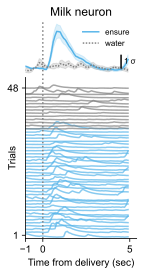

In [222]:
### plot single cell traces example

n_boot = 1000
# n_boot = 10 # for fast plotting

file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'

# file_name = 'BES0427_21.06.25_CaMK2_chocolate_water_mild.npy' # 81 is a good milk neuron
file_name = 'BES0427_21.06.03_CaMK2_strawberry_water_severe.npy' # 65 is a good milk neuron, #90/91 is non-selective
# file_name = 'BES0225_20.09.28_CaMK2_chocolate_water_mild.npy' # 84 is non-selective
# file_name = 'BES0225_20.10.07_CaMK2_strawberry_water_mild.npy' # 105, 116 is good water neurons, #68 is non-selective

file_name = os.path.join(file_folder,file_name)
PETH_binge_on, PETH_binge_off, PETH_slow_milk, PETH_slow_water, PETH_lick_binge, PETH_lick_slow, PETH_pump_binge, PETH_pump_slow = load_npy(file_path=file_name)



# i = 81 # for 210623 milk neuron
i = 65 # for 210603, milk neuron

# i = 90 # for 210603, nonselective neuron
# i = 91 # for 210603, nonselective neuron
# i = 68 # for 201007, nonselective

# i = 105 # for 201007, water neuron
# i = 34 # for 210623 water neuron

## search possible neurons with higher responses
# isort = np.argsort(-PETH_slow_water[:,:,50:75].mean(axis=(1,2)))
# isort = np.argsort(-PETH_slow_milk[:,:,50:75].mean(axis=(1,2)))

# for i in isort[0:5]:
if True:
    df_milk = np2df_long(PETH_slow_milk[i])
    df_water = np2df_long(PETH_slow_water[i])

    fig, axes = plt.subplots(figsize=[2,4],nrows=2,sharex=True,gridspec_kw={'height_ratios': [1,3],'hspace':0.02})

    sns.lineplot(data=df_milk,x='Time (sec)',y='zs-dff',ax=axes[0],color=my_color_map[0],label='ensure',n_boot=n_boot,errorbar='se')
    sns.lineplot(data=df_water,x='Time (sec)',y='zs-dff',ax=axes[0],color='grey',dashes=(1,1),label='water',n_boot=n_boot,errorbar='se')
    axes[0].legend(fontsize=8,frameon=False,loc=1)
    axes[0].set_xlim(xmin=-1)
    axes[0].set_axis_off()
    x_offest = 0.5
    axes[0].text(4.5+x_offest,0.5,s='1 \u03C3',ha='center',va='center',size=8)
    axes[0].plot([4+x_offest,4+x_offest],[0,1],c='k')
    axes[0].set_axis_off()

    t_scale = np.arange(-1,5,0.1)
    for j in range(PETH_slow_milk.shape[1]):
        axes[1].plot(t_scale,PETH_slow_milk[i,j,40:]/3+j+1,c=my_color_map[0],alpha=0.7)
    for l in range(PETH_slow_water.shape[1]):
        axes[1].plot(t_scale,PETH_slow_water[i,l,40:]/3+j+l+1,c='grey',alpha=0.7)

    axes[1].set_xticks([-1,0,5])
    axes[1].set_yticks([1,j+l+1])
    axes[1].set_ylabel('Milk deliveries',labelpad=-10)
    axes[1].set_ylim(ymin=0)

    axes[1].set_xlabel('Time from delivery (sec)')
    axes[1].set_ylabel('Trials')
    sns.despine(ax=axes[0],left=True,bottom=True)
    sns.despine(ax=axes[1])
    for k in range(2):
        axes[k].axvline(x=0,c='grey',ls=':')

    # print(i)
    # plt.show()


if i  in [81,65]:
    axes[0].set_title('Milk neuron')
    plot_name = f'1_example_neuron_milk_{i}'
    save_plot_pdf(plot_name)
elif i in [90,91,68]:
    axes[0].set_title('Non-selective neuron')
    plot_name = f'1_example_neuron_nonselective_{i}'
    save_plot_pdf(plot_name)
elif i in [34,105]:
    axes[0].set_title('Water neuron')
    plot_name = f'1_example_neuron_water_{i}'
    save_plot_pdf(plot_name)

else:
    pass


In [223]:
## load BES0224 200818 for example plotting
## load inscopix & phenosys data

Phenosys_folder = '/Users/hunglo/Documents/inscopix_csv/Phenosys_csv/'
extension = 'csv'
os.chdir(Phenosys_folder)
result = sorted(glob.glob('*.{}'.format(extension)))

result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa data
result = [r for r in result if 'BES0224' in r]

## loop through all files
for file_path in tqdm(result[:1]):
  file_path = os.path.join(Phenosys_folder,file_path)
  mouse_id = file_path.split('_Inscopix-')[0].split('/')[-1]
  date     = file_path.split('_Inscopix-')[1].split('_')[0]
  print(mouse_id,date)
  L1,P1,P2,PAll = binge.load_phenosys(file_path)
  L1 = np.pad(L1, (0, 1), 'constant', constant_values=(np.nan,3000)) ## add a very far lick event to prevent a conditional error later for excluding no lick slow events
  L1_,P1_,P2_,PAll_ = binge.load_phenosys_nofilter(file_path)

  PETH_lick_slow, PETH_pump_slow = {},{}
  PETH_lick_binge, PETH_pump_binge = {},{}
  PETH_trace_binge_on,PETH_trace_binge_off = {},{}
  PETH_trace_milk,PETH_trace_water = {},{}

  ## make a condition here to check if we have the corresponding Ca2+
  df_accepted, df_z, time_difference = binge.loadandsync_incopix_csv(file_path)

df_z

  0%|          | 0/1 [00:00<?, ?it/s]

BES0224 20.08.18
time difference: -12.159000000000006
num of neurons: 385


100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


C00_0     C01_0     C04_0     C05_0     C06_0     C08_0  \
-12.159   -0.399522 -0.627086 -0.737924 -1.125511 -1.052487 -1.141817   
-12.109    0.400438 -0.627086 -0.737924 -0.226892  1.065318 -1.141817   
-12.059    0.317492 -0.627086 -0.737924  0.533901  0.879784 -1.141817   
-12.009    0.243147 -0.627086 -0.145462  0.410785  1.258167 -1.141817   
-11.959    0.987301  1.515446  0.095156  0.296802  1.093714 -1.141817   
...             ...       ...       ...       ...       ...       ...   
 1503.491  0.383820 -0.626733 -0.019206  0.777544 -0.623313  0.352913   
 1503.541  0.302597 -0.626767 -0.110489  0.636351 -0.660911  0.617211   
 1503.591  0.229797 -0.626798 -0.190178  0.505633 -0.695216  0.445876   
 1503.641  0.164544 -0.626826 -0.185496  0.384614 -0.726515  0.291230   
 1503.691  0.106058 -0.626851 -0.255658  0.272574 -0.755072  0.151647   

              C09_0     C13_0     C14_0     C15_0  ...     C70_9     C72_9  \
-12.159   -1.303540 -1.175212 -0.966375 -0.803509  ... -1.044735 -1.070238   
-12.109   -1.303540 -1.175212  4.224781  0.353273  ... -1.044735 -1.070238   
-12.059   -1.303540 -1.175212  4.393776  0.255604  ... -1.044735 -1.070238   
-12.009   -1.303540 -1.175212  3.937001  0.166181  ... -1.044735 -1.070238   
-11.959   -1.303540 -1.173832  3.519151  0.084308  ... -1.044735 -1.070238   
...             ...       ...       ...       ...  ...       ...       ...   
 1503.491 -1.303539  0.242893 -0.040991 -0.364277  ... -0.737542 -0.622010   
 1503.541 -1.303539  0.111233 -0.119849 -0.401362  ... -0.754076 -0.686322   
 1503.591 -1.303539 -0.008203  0.060759 -0.435316  ... -0.769720 -0.741407   
 1503.641 -1.303539 -0.116551 -0.026770 -0.466404  ... -0.784522 -0.333574   
 1503.691 -1.303539 -0.214839 -0.106840 -0.494866  ... -0.798527 -0.439272   

              C73_9     C74_9     C75_9     C77_9     C78_9     C80_9  \
-12.159   -0.857850 -0.946536 -0.862231 -1.217694 -1.155859 -1.228072   
-12.109    0.931936  0.066460 -0.862231 -0.488354  0.817714 -1.228072   
-12.059    0.772847 -0.093948 -0.862231 -0.557945  0.510503 -1.228072   
-12.009    0.627900 -0.228957 -0.862231 -0.620897  0.251115  0.457864   
-11.959    0.495835 -0.342586 -0.782218 -0.677842  1.873496  0.274327   
...             ...       ...       ...       ...       ...       ...   
 1503.491 -0.637679 -0.318149  0.048203 -0.026630 -0.869427  0.722377   
 1503.541 -0.657249 -0.417655 -0.031701  0.259683 -0.914013  0.510046   
 1503.591 -0.675080 -0.431508 -0.104592  1.231623 -0.951659  0.878060   
 1503.641 -0.691326 -0.513063 -0.158495  1.257921  0.012363  0.648780   
 1503.691 -0.706128 -0.581704 -0.220258  1.021705 -0.011102  0.444460   

              C81_9     C82_9  
-12.159   -1.187383 -1.013020  
-12.109   -1.187383  0.808930  
-12.059   -1.187383  0.869236  
-12.009   -1.187383  0.937825  
-11.959   -1.187383  1.249143  
...             ...       ...  
 1503.491  0.158430 -0.504844  
 1503.541  0.027504 -0.342990  
 1503.591 -0.090686 -0.056041  
 1503.641  0.044952 -0.133987  
 1503.691 -0.074936 -0.205585  

[30318 rows x 385 columns]

In [229]:
df_accepted

C00_0         C01_0     C04_0      C05_0      C06_0  \
-12.159    0.000000  0.000000e+00  0.000000   0.000000   0.000000   
-12.109    4.617240  0.000000e+00  0.000000   7.503592  18.783050   
-12.059    4.138491  4.768372e-07  0.000000  13.856320  17.137530   
-12.009    3.709382  0.000000e+00  4.186768  12.828280  20.493450   
-11.959    8.004519  1.212907e+01  5.887149  11.876510  19.034900   
...             ...           ...       ...        ...        ...   
 1503.491  4.521327  2.001100e-03  5.078987  15.890770   3.806395   
 1503.541  4.052521  1.807414e-03  4.433913  14.711790   3.472930   
 1503.591  3.632326  1.632475e-03  3.870770  13.620280   3.168679   
 1503.641  3.255699  1.474468e-03  3.903862  12.609750   2.891082   
 1503.691  2.918124  1.331755e-03  3.408040  11.674200   2.637804   

                  C08_0     C09_0      C13_0      C14_0     C15_0  ...  \
-12.159    0.000000e+00  0.000000   0.000000   0.000000  0.000000  ...   
-12.109    0.000000e+00  0.000000   0.000000  47.128490  9.059711  ...   
-12.059   -4.768372e-07  0.000000  -0.000004  48.662730  8.294781  ...   
-12.009    0.000000e+00  0.000000   0.000000  44.515850  7.594438  ...   
-11.959    0.000000e+00  0.000000   0.010803  40.722350  6.953225  ...   
...                 ...       ...        ...        ...       ...  ...   
 1503.491  1.162023e+01  0.000012  11.105630   8.401204  3.439986  ...   
 1503.541  1.367492e+01  0.000011  10.074560   7.685281  3.149541  ...   
 1503.591  1.234294e+01  0.000010   9.139217   9.324950  2.883620  ...   
 1503.641  1.114070e+01  0.000009   8.290713   8.530309  2.640150  ...   
 1503.691  1.005556e+01  0.000008   7.520986   7.803384  2.417237  ...   

              C70_9     C72_9      C73_9     C74_9     C75_9      C77_9  \
-12.159    0.000000  0.000000   0.000000  0.000000  0.000000   0.000000   
-12.109    0.000000  0.000000  15.934090  6.956381  0.000000   3.835664   
-12.059    0.000000  0.000000  14.517760  5.854834  0.000000   3.469676   
-12.009    0.000000  0.000000  13.227320  4.927715  0.000000   3.138609   
-11.959   -0.000008  0.000000  12.051580  4.147408  0.561775   2.839131   
...             ...       ...        ...       ...       ...        ...   
 1503.491  8.453863  4.374636   1.960136  4.315217  6.392257   6.263912   
 1503.541  7.998855  3.746957   1.785905  3.631899  5.831243   7.769660   
 1503.591  7.568337  3.209337   1.627161  3.536765  5.319466  12.881180   
 1503.641  7.160991  7.189720   1.482528  2.976715  4.941005  13.019480   
 1503.691  6.775568  6.158127   1.350750  2.505350  4.507360  11.777200   

               C78_9      C80_9      C81_9      C82_9  
-12.159     0.000000   0.000000   0.000000   0.000000  
-12.109    12.943400   0.000000   0.000000  21.415090  
-12.059    10.928600   0.000002   0.000000  22.123920  
-12.009     9.227437   9.579468   0.000000  22.930110  
-11.959    19.867600   8.536617   0.000000  26.589330  
...              ...        ...        ...        ...  
 1503.491   1.878522  11.082430  10.966590   5.973069  
 1503.541   1.586108   9.875968   9.899714   7.875492  
 1503.591   1.339212  11.967020   8.936624  11.248270  
 1503.641   7.661617  10.664250  10.041890  10.332100  
 1503.691   7.507724   9.503307   9.064965   9.490544  

[30318 rows x 385 columns]

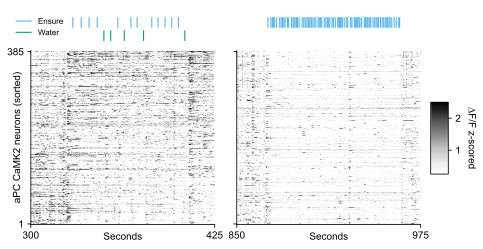

In [273]:
## plotting for this example
### Add lick rate to the plot?

x_lim_1 = [275,425] 
x_lim_1 = [300,425] 
x_lim_2 = [825,975] 
x_lim_2 = [850,975] 

extent_1 = [x_lim_1[0],x_lim_1[1],df_z.shape[1],0]
extent_2 = [x_lim_2[0],x_lim_2[1],df_z.shape[1],0]

vmin = 0.25
vmax = 2.5

# # a.u.
# vmin = 0
# vmax= 100

xmin_sort = 325
xmax_sort = 410

# data = df_accepted
data = df_z

# # Initiate plotting
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=[7,4], gridspec_kw={'height_ratios': [1.25, 5],'hspace':0,'wspace':0.12},sharex='col',sharey='row')


# ## Number of pump1 and pump2 for the delivery n on the fig legend
# deliver_milk, deliver_water = length_delivery(Pump1_clean,Pump2_clean)
# y_offset = df_event_binary.shape[-1]+3

# df_z
# xmin_sort
# xmax_sort
# isort = np.argsort(event_count)
# sorted_cell_name = df_event_binary_accepted.columns[isort]
diff_ = data[xmin_sort-120:xmin_sort].mean()-data[xmin_sort:xmax_sort].mean()
isort = np.argsort(-diff_)
sorted_cell_name = data.columns[isort]
# sorted_cell_name

# # upper left
GPIO_plot = [P1,P2]
axes[0,0].eventplot(GPIO_plot,color=[my_color_map[0],my_color_map[2]],lineoffsets=[1,0],linewidths=1.1, linelength=0.8,alpha=1)
axes[0,1].eventplot(GPIO_plot,color=[my_color_map[0],my_color_map[2]],lineoffsets=[1,0],linewidths=1.1, linelength=0.8,alpha=1)

mx = axes[1,0].imshow(data.reindex(columns=sorted_cell_name)[x_lim_1[0]:x_lim_1[1]].T,cmap='Greys',aspect='auto',vmin=vmin,vmax=vmax,extent=extent_1,interpolation='none')
axes[1,1].imshow(data.reindex(columns=sorted_cell_name)[x_lim_2[0]:x_lim_2[1]].T,cmap='Greys',aspect='auto',vmin=vmin,vmax=vmax,extent=extent_2,interpolation='none')

labels=['Ensure','Water']
axes[0,0].legend(labels,frameon=False,fontsize=8,loc=[-0.1,0.25])

for row in range(2):
  for col in range(2):
    if row == 0:
      sns.despine(ax=axes[row,col],left=True,bottom=True)
    else:
      sns.despine(ax=axes[row,col])

# sns.despine(ax=ax0, left=True,bottom=True)
axes[0,0].set_yticks([])
axes[0,1].set_yticks([])

axes[1,0].set_xticks(x_lim_1)
axes[1,1].set_xticks(x_lim_2)
axes[1,0].set_xlabel('Seconds',labelpad=-8)
axes[1,1].set_xlabel('Seconds',labelpad=-8)
axes[1,0].set_ylabel('aPC CaMK2 neurons (sorted)',labelpad=-15)
axes[1,0].set_yticks([1,df_z.shape[-1]])
axes[1,0].set_ylim(ymin=0,ymax=df_z.shape[-1]+2)

## shrink for color bar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.035, 0.25])
cbar_ax.get_yaxis().labelpad = 15
fig.colorbar(mx, cax=cbar_ax,ticks=[1,2])
cbar_ax.set_ylabel('∆F/F z-scored', rotation=270,labelpad=15)
# cbar_ax.set_yticklabels([1,2])

plot_name = '1_example_heatmap_slow_binge'
save_plot_pdf(plot_name)

posx and posy should be finite values


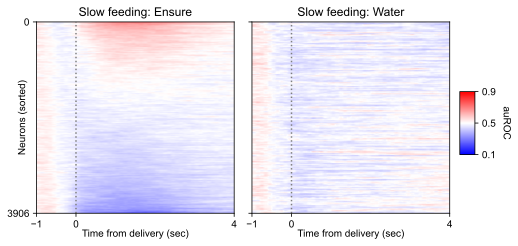

In [57]:
## make heat map of auroc

import matplotlib.colors as mcolors

neuron_num = straw_auroc.shape[0]

isort = np.argsort(-straw_auroc[:,50:75].mean(axis=1))
isort_w = np.argsort(-water_auroc[:,50:75].mean(axis=1))

vmin = round(np.array(straw_auroc).min(),1)
vmax = round(np.array(water_auroc).max(),1)
vmax = 0.9
vcenter = 0.5

norm = mcolors.TwoSlopeNorm(vmin=vmin, vmax = vmax, vcenter=vcenter)

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=[7,3.5],sharex=True,sharey=True)
extent = [-1,4,straw_auroc.shape[0],0]

mx = axes[0].imshow(straw_auroc[isort,40:90],cmap='bwr',aspect='auto',norm=norm,extent=extent,interpolation=None)
axes[1].imshow(water_auroc[isort,40:90],cmap='bwr',aspect='auto',norm=norm,extent=extent,interpolation=None)

for col in range(2):
  axes[col].axvline(x=0,ls=':',c='grey')
  axes[col].set_xlabel('Time from delivery (sec)',labelpad = 0)
  axes[col].set_xticks([-1,0,4])
  axes[col].set_yticks([0,neuron_num])

axes[0].set_title('Slow feeding: Ensure')
axes[1].set_title('Slow feeding: Water')

axes[0].set_ylabel('Neurons (sorted)',labelpad = -20)
# axes[1,0].set_ylabel('Neuron-Flavor pair (sorted by water)')
plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.375, 0.03, 0.25])
cbar_ax.get_yaxis().labelpad = 15
fig.colorbar(mx, cax=cbar_ax,ticks=[vmin, 0.5, vmax])
cbar_ax.set_ylabel('auROC', rotation=270)
cbar_ax.set_yticklabels([str(round(vmin,1)), '0.5', str(round(vmax,1))])

plot_name = '1_auroc_heatmap_milk_water'
save_plot_pdf(plot_name)

In [55]:
# ## change file name directly here
# file_folder = '/Users/hunglo/Documents/inscopix_csv/auroc_npy/'
# extension = 'npy'
# os.chdir(file_folder)
# result = sorted(glob.glob('*.{}'.format(extension)))
# result = [r for r in result if 'SNA' not in r] # exclude dopa & sero data
# result = [ r for r in result if 'strawberry' in r or 'chocolate' in r or 'vanilla' in r]

# for r in result[:]:
#     if '.' not in r.split('_')[2]:
#         old_name = os.path.join(file_folder,r)
#         date = r.split('_')[2]
#         datewdot = '.'.join(a+b for a,b in zip(date[::2], date[1::2]))
#         mouse_id = r.split('_')[1]
#         celltype = r.split('_')[3]
#         flavor = r.split('_')[4]
#         new_r    = f'auroc_{mouse_id}_{datewdot}_{celltype}_{flavor}'
#         os.rename(old_name,new_r)
#     else:
#         old_name = os.path.join(file_folder,r)
#         date = r.split('_')[2]
#         datenodot = date.replace('.','')
#         datewdot = '.'.join(a+b for a,b in zip(datenodot[::2], datenodot[1::2]))
#         mouse_id = r.split('_')[1]
#         celltype = r.split('_')[3]
#         flavor = r.split('_')[4]
#         new_r    = f'auroc_{mouse_id}_{datewdot}_{celltype}_{flavor}'
#         os.rename(old_name,new_r)

#         print('fixed with new name')

# # # Absolute path of a file
# # old_name = r"E:\demos\files\reports\details.txt"
# # new_name = r"E:\demos\files\reports\new_details.txt"

# # # Renaming the file
# # os.rename(old_name, new_name)




fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name
fixed with new name


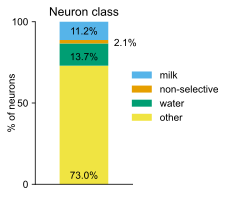

In [58]:
## bargraph

num_milk_neuron = len(straw_idx_pos)
num_water_neuron = len(water_idx_pos)
num_nonselect_neuron = len(both_idx)
num_other_neuron = len(other_idx)

labels = 'Milk neurons', 'Both', 'Water neurons', 'not responding'
sizes = [num_milk_neuron,
         num_nonselect_neuron,        
         num_water_neuron,
         num_other_neuron]
sizes /= np.sum(sizes)
sizes = sizes*100 # make 100%

cell_num_list_T = pd.DataFrame(sizes[::-1]).T
cell_num_list_T.rename({3: 'milk', 2: 'non-selective', 1:'water',0:'other'}, axis=1, inplace=True)

fig1, ax1 = plt.subplots(figsize=[1.75,3])
cell_num_list_T.plot(kind='bar',stacked=True,color=my_color_map[3::-1],ax=ax1)
ax1.set_xticks([])
ax1.legend()  # reverse both handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
for idx,x in enumerate(cell_num_list_T.iloc[0,:]):
  steps = [0, *cell_num_list_T.iloc[0,:].values.cumsum()]
  text = f'{round(x,2):.1f}'
  if idx==2:
    ax1.text(0.425,steps[idx],text+'%',ha='center',va='center')
  else: 
    ax1.text(0,steps[idx]+5,text+'%',ha='center',va='center')
    
order = [3,2,1,0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper left',bbox_to_anchor=(0.9, 0.75), frameon=False,title=None,fontsize=10)
plt.ylabel('% of neurons',labelpad=-5)
plt.title('Neuron class')
plt.yticks([0,50,100])
plt.ylim([0,100])
sns.despine()

plot_name = '1_neuron_types_bargraph_all'
save_plot_pdf(plot_name)

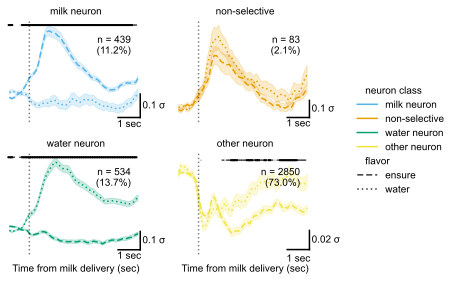

In [66]:
## Ca2+ traces for slow feeding milk & water
def deco_sns(data, **kws):
    n = len(data['idx_cell'].unique())
    ax = plt.gca()
    ax.axvline(x=0,ls=':',color='k',alpha=0.5)
    if n == total_neuron_num:
        ax.text(.9,.85,f'n = {n}',transform=ax.transAxes,ha='right',va='top') # annotate n number, no % for all neurons
    else:
        ax.text(.9,.85,f'n = {n}\n({round(n/total_neuron_num*100,1)}%)',transform=ax.transAxes,ha='right',va='top') # annotate n number

def deco_stats(data,**kws):
    t_sign_05 = get_qvalue(data,threshold_q=0.05)
    t_sign_01 = get_qvalue(data,threshold_q=0.01)
    t_sign_001 = get_qvalue(data,threshold_q=0.001)
    ax = plt.gca()
    ymax = ax.get_ylim()[1]
    for t in t_sign_05:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=0.3,lw=1)
    for t in t_sign_01:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=0.6,lw=1.5)
    for t in t_sign_001:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=1,lw=2)
    ax.set_xlim(xmin=-1)

def get_qvalue(data, threshold_q=0.05):
    from scipy import stats
    from statsmodels.stats.multitest import fdrcorrection
    # threshold_q=threshold_q/4 # in case we need to account for 4 clusters of neurons
    t_sign = []
    p_concat = []
    slow_data = data[data['flavor']=='ensure']
    binge_data = data[data['flavor']=='water']
    for t in data['Time (sec)'].unique():
        slow_value  = slow_data[slow_data['Time (sec)']==t]['zs-dff'].values
        binge_value = binge_data[binge_data['Time (sec)']==t]['zs-dff'].values
        p_val = stats.ttest_ind(slow_value, binge_value, equal_var=False)[1]
        p_concat.append(p_val)

    rejected, q_value = fdrcorrection(np.array(p_concat),method='poscorr')
    adj_p_sign_idx = q_value<threshold_q
    t_scale = np.arange(-1,4.9,0.1)
    t_sign = t_scale[adj_p_sign_idx]

    return t_sign

def deco_scale(data,**kws):
    ax = plt.gca()
    yticks = ax.get_yticks()
    yunit = yticks[1]-yticks[0]
    yunit = round(yunit,2)
    if yunit>0.1:
        yunit=0.1
    if yunit<0.05:
        # yunit = 0.05
        ax.set_ylim(np.array(ax.get_ylim())*1.2)
        ylims = ax.get_ylim()
        y_offset = 0.005
        y_bottom,y_top = ylims[0]+y_offset, ylims[0]+yunit+y_offset
        ax.plot([5,5],[y_bottom,y_top],c='k')
        ax.text(5.1,y_bottom+yunit/2,f'{yunit} \u03C3',va='center',ha='left') # \u03C3 is sigma=sd
        ax.plot([4,5],[y_bottom,y_bottom],c='k')
        ax.text(4.5,y_bottom-0.005,'1 sec',ha='center',va='top')
        # ax.text(0.9,0.05,s='1 sec',ha='center',va='center',transform=ax.transAxes)
    else:    
        ylims = ax.get_ylim()
        y_bottom,y_top = ylims[0], ylims[0]+yunit
        ax.plot([5,5],[y_bottom,y_top],c='k')
        ax.text(5.1,y_bottom+yunit/2,f'{yunit} \u03C3',va='center',ha='left') # \u03C3 is sigma=sd
        ax.plot([4,5],[y_bottom,y_bottom],c='k')
        ax.text(4.5,y_bottom-0.01,'1 sec',ha='center',va='top')

    # ax.set_axis_off()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.set_xlabel('Time from milk delivery (sec)',labelpad=10)
    sns.despine(bottom=True,left=True,ax=ax)



total_neuron_num = len(data_concat_slow['idx_cell'].unique()) # this variable will be used for deco_sns() later
hue_num = 5
# kw = {'dashes':[(0,0),(1,1)]}
col_order = ['all neuron','milk neuron','non-selective','water neuron','other neuron']
col_order = ['milk neuron','non-selective','water neuron','other neuron'] # exclude all neuron
g = sns.relplot(data=data_concat_slow[:],x='Time (sec)',y='zs-dff',col_wrap=2,
            col='neuron class',col_order=col_order,
            hue='neuron class',hue_order=col_order,palette=my_color_map_grey[1:hue_num],
            style='flavor',style_order=['ensure','water'],dashes=[(4,2),(1,2)],
            kind="line",height=2,aspect=1.25,errorbar='se',
            facet_kws={'sharey': False, 'sharex': True})

g.map_dataframe(deco_sns)
g.map_dataframe(deco_stats)
g.map_dataframe(deco_scale)
g.set_titles('{col_name}')
# g.fig.subplots_adjust(top=.825, wspace=0.18)
# g.fig.subplots_adjust(top=.85, wspace=0.18)
# g.fig.suptitle(f'{Celltype} slow feeding responses')

if 'camk2' in Celltype:
    plot_name = f'1_{Celltype}_neurontype_milk_water_traces'
elif 'gc' in Celltype:
    plot_name = f'2_{Celltype}_neurontype_milk_water_traces'
elif 's2' in Celltype:
    plot_name = f'2x_{Celltype}_neurontype_milk_water_traces'
else:
    plot_name = f'3_{Celltype}_neurontype_milk_water_traces'

save_plot_pdf(plot_name)



In [53]:
data_concat_slow


Time (sec)          zs-dff           quantile       idx_cell          \
flavor      ensure water    ensure     water   ensure water   ensure   water   
15703         -0.9   NaN -0.026246       NaN     None   NaN     10.0     NaN   
15704         -0.9   NaN -0.005928       NaN     None   NaN     20.0     NaN   
15705         -0.9   NaN -0.001202       NaN     None   NaN     43.0     NaN   
15706         -0.9   NaN -0.106280       NaN     None   NaN     49.0     NaN   
15707         -0.9   NaN -0.010745       NaN     None   NaN     67.0     NaN   
...            ...   ...       ...       ...      ...   ...      ...     ...   
1562395        NaN   4.9       NaN  0.026039      NaN  None      NaN  3896.0   
1562396        NaN   4.9       NaN -0.709237      NaN  None      NaN  3897.0   
1562397        NaN   4.9       NaN  0.145845      NaN  None      NaN  3898.0   
1562398        NaN   4.9       NaN -0.552144      NaN  None      NaN  3904.0   
1562399        NaN   4.9       NaN  0.671838      NaN  None      NaN  3905.0   

        neuron class              
flavor        ensure       water  
15703    milk neuron         NaN  
15704    milk neuron         NaN  
15705    milk neuron         NaN  
15706    milk neuron         NaN  
15707    milk neuron         NaN  
...              ...         ...  
1562395          NaN  all neuron  
1562396          NaN  all neuron  
1562397          NaN  all neuron  
1562398          NaN  all neuron  
1562399          NaN  all neuron  

[921816 rows x 10 columns]

(82, 8)


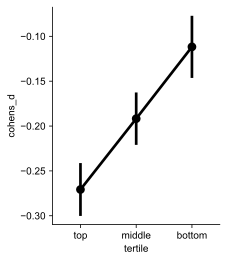

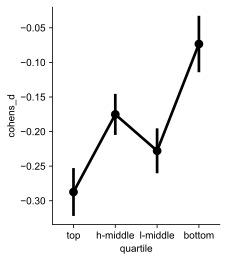

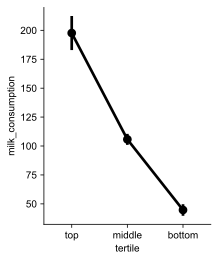

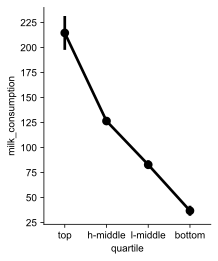

   group1  group2      Diff     Lower     Upper   q-value   p-value
0     top  middle  0.078961 -0.023868  0.181790  2.594046  0.165312
1     top  bottom  0.158982  0.058899  0.259065  5.366230  0.001000
2  middle  bottom  0.080021 -0.021054  0.181096  2.674501  0.148017
     group1    group2      Diff     Lower     Upper   q-value   p-value
0       top  h-middle  0.112165 -0.012759  0.237089  3.333638  0.094117
1       top    bottom  0.213990  0.093620  0.334359  6.600625  0.001000
2       top  l-middle  0.059569 -0.063705  0.182843  1.794147  0.575755
3  h-middle    bottom  0.101825 -0.021743  0.225393  3.059536  0.142635
4  h-middle  l-middle  0.052596 -0.073803  0.178995  1.544957  0.673698
5    bottom  l-middle  0.154421  0.032522  0.276320  4.703409  0.007219


In [16]:
## extract sessions where only selected cell type, fasting state, anosmic state are processed

def select_sessions(df_estimate_concat, Celltype='apc_camk2', fasted = False, anosmic = False, window_size = '0_4'):
    data = df_estimate_concat[df_estimate_concat['fasted'] == fasted]
    data = data[data['anosmic']==anosmic]
    data = data[data['window_size']==window_size]
    data = data[data['Celltype']==Celltype]
    print(data.shape)

    ## separate data by behavior ranking (%) & by absolute milk consumption values
    data['milk_rank_pct'] = data['milk_consumption'].rank(pct=True)
    data['tertile']       = pd.qcut(data['milk_rank_pct'],   q = 3,    labels=['bottom','middle','top'])
    data['quartile']      = pd.qcut(data['milk_rank_pct'],   q = 4,    labels=['bottom','l-middle','h-middle','top'])
    data['tertile_abs']   = pd.cut(data['milk_consumption'], bins = 3, labels=['bottom','middle','top'])
    data['quartile_abs']  = pd.cut(data['milk_consumption'], bins = 4, labels=['bottom','l-middle','h-middle','top'])

    cohensd_table = data.copy()

    return cohensd_table





## tertile data by milk consumption
## only get data without anosmic & fasting
data = df_estimate_concat[df_estimate_concat['fasted'] == False]
data = data[data['anosmic']==False]
data = data[data['window_size']=='0_4']
data = data[data['Celltype']=='apc_camk2']
# data = data[data['Celltype']=='apc_pv']
# data = data[data['Celltype']=='apc_sst']

# data = data[data['Celltype']=='gc']
# data = data[data['Celltype']=='s2']

print(data.shape)

## separate data by behavior ranking (%) & by absolute milk consumption values
data['milk_rank_pct'] = data['milk_consumption'].rank(pct=True)
data['tertile']       = pd.qcut(data['milk_rank_pct'],   q = 3,    labels=['bottom','middle','top'])
data['quartile']      = pd.qcut(data['milk_rank_pct'],   q = 4,    labels=['bottom','l-middle','h-middle','top'])
data['tertile_abs']   = pd.cut(data['milk_consumption'], bins = 3, labels=['bottom','middle','top'])
data['quartile_abs']  = pd.cut(data['milk_consumption'], bins = 4, labels=['bottom','l-middle','h-middle','top'])

cohensd_table = data.copy()

# plt.figure(figsize=[3,4])
# sns.pointplot(data=data,x='tertile',y='cohens_d',color='k',errorbar='se',order=['top','middle','bottom'])
# sns.despine()
# plt.show()

# plt.figure(figsize=[3,4])
# sns.pointplot(data=data,x='quartile',y='cohens_d',color='k',errorbar='se',order=['top','h-middle','l-middle','bottom'])
# sns.despine()
# plt.show()

# plt.figure(figsize=[3,4])
# sns.pointplot(data=data,x='tertile',y='milk_consumption',color='k',errorbar='se',order=['top','middle','bottom'])
# sns.despine()
# plt.show()

# plt.figure(figsize=[3,4])
# sns.pointplot(data=data,x='quartile',y='milk_consumption',color='k',errorbar='se',order=['top','h-middle','l-middle','bottom'])
# sns.despine()
# plt.show()

from scipy import stats
# stats.f_oneway(data[data['tertile']=='top']['cohens_d'].values, data[data['tertile']=='middle']['cohens_d'].values,data[data['tertile']=='bottom']['cohens_d'].values)
import statsmodels.api as sm
from statsmodels.formula.api import ols

# model = ols('cohens_d ~ C(tertile)', data=data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# anova_table

from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=data, res_var='cohens_d', xfac_var='tertile', anova_model='cohens_d ~ C(tertile)')
print(res.tukey_summary)

res = stat()
res.tukey_hsd(df=data, res_var='cohens_d', xfac_var='quartile', anova_model='cohens_d ~ C(quartile)')
print(res.tukey_summary)

## qqplot
# sm.qqplot(res.anova_std_residuals, line='45')
# plt.xlabel("Theoretical Quantiles")
# plt.ylabel("Standardized Residuals")
# plt.show()

# from scipy import stats
# stats.f_oneway(data[data['tertile']=='top']['milk_consumption'].values, data[data['tertile']=='middle']['milk_consumption'].values,data[data['tertile']=='bottom']['milk_consumption'].values)
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# model = ols('milk_consumption ~ C(tertile)', data=data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# anova_table

# from bioinfokit.analys import stat
# # perform multiple pairwise comparison (Tukey's HSD)
# # unequal sample size data, tukey_hsd uses Tukey-Kramer test
# res = stat()
# res.tukey_hsd(df=data, res_var='milk_consumption', xfac_var='tertile', anova_model='milk_consumption ~ C(tertile)')
# print(res.tukey_summary)


https://www.reneshbedre.com/blog/anova.html

anova tutorial


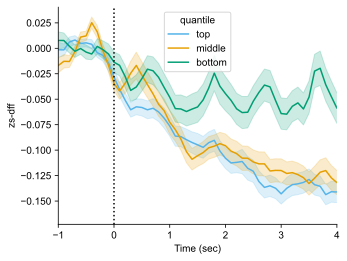

In [17]:
## now use quantile data to generate PETH data

## load PETH from npy and concat all together
# select_data = data[data['tertile']=='top']
# select_data = data[data['tertile_abs']=='top']

# mouse_id_list = sorted(select_data['mouse_id'].unique())

def get_npy_path(mouse_id,date):
    file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
    extension = 'npy'
    os.chdir(file_folder)
    result = sorted(glob.glob('*.{}'.format(extension)))
    result = [r for r in result if mouse_id in r]
    if '.' in date:
        datewithdot = date
    else:
        datewithdot = f'{date[0:2]}.{date[2:4]}.{date[4:6]}'
    result = [r for r in result if datewithdot in r]
    # print(result)
    file_path = os.path.join(file_folder,result[0])
    return file_path

def concat_PETH_binge(select_data,mouse_id_list):
    PETH_binge_on_concat = np.zeros([1,100])
    # print(PETH_binge_on_concat.shape)
    for mouse_id in mouse_id_list:
        # print(mouse_id)
        date_list = select_data[select_data['mouse_id']==mouse_id]['date'].values.astype('str')
        for date in date_list:
            # print(f'>{date}')
            PETH_binge_on,_,_,_,_,_,_,_ = load_npy(get_npy_path(mouse_id,date))
            PETH_avg = np.mean(PETH_binge_on,axis=1) # trial average
            # print(PETH_avg.shape[0])
            PETH_binge_on_concat = np.vstack([PETH_binge_on_concat,PETH_avg])
    # print(PETH_binge_on_concat.shape)
    PETH_binge_on_concat = PETH_binge_on_concat[~np.all(PETH_binge_on_concat == 0, axis=1)] # remove first row
    # print(PETH_binge_on_concat.shape)
    return PETH_binge_on_concat

def np2df_long(PETH_binge_on_concat,q=None):
    df_ = pd.DataFrame(PETH_binge_on_concat)
    df_long = pd.melt(df_.reset_index(),id_vars='index',value_name='zs-dff',var_name='Time (sec)')
    df_long['Time (sec)']=(df_long['Time (sec)'].values/10)-5
    df_long['quantile'] = q
    return df_long

## load PETH binge based on their given quantiles

def load_PETH_binge_quantile(data, quantile = 'tertile'):
    quantile_list = data[quantile].unique().to_list()
    # print(quantile_list)
    df_PETH_binge_on_concat_quantile = pd.DataFrame([])
    for q in quantile_list:
        select_data = data[data[quantile]==q]
        mouse_id_list = sorted(select_data['mouse_id'].unique())
        PETH_binge_on_concat = concat_PETH_binge(select_data,mouse_id_list)
        df_PETH_binge_on_concat = np2df_long(PETH_binge_on_concat,q=q)
        df_PETH_binge_on_concat_quantile = pd.concat([df_PETH_binge_on_concat_quantile,df_PETH_binge_on_concat])
        df_PETH_binge_on_concat_quantile = df_PETH_binge_on_concat_quantile.reset_index(drop=True)
    return df_PETH_binge_on_concat_quantile

# quantile = 'quartile'
quantile = 'tertile'

if quantile == 'quartile':
    hue_order = ['top','h-middle','l-middle','bottom']
elif quantile == 'tertile':
    hue_order = ['top','middle','bottom']
df_PETH_binge_on_concat_quantile = load_PETH_binge_quantile(data, quantile = quantile)
# df_PETH_binge_on_concat_quantile = load_PETH_binge_quantile(data, quantile = 'tertile')

# df_PETH_binge_on_concat_quantile

fast_plot = True
if fast_plot:
    n_boot = 50
else:
    n_boot = 1000
plt.figure(figsize=[5,4])

sns.lineplot(data=df_PETH_binge_on_concat_quantile,x='Time (sec)',y='zs-dff',hue='quantile', n_boot=n_boot,errorbar='se',palette=my_color_map[0:len(df_PETH_binge_on_concat_quantile['quantile'].unique())],hue_order=hue_order)

plt.axvline(x=0,ls=':',c='k')
sns.despine()
plt.xlim(xmin=-1,xmax=4)
plt.show()

In [17]:
## next steps: pre-calculate auroc and save as npy, so later we just need to repload the file

file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
extension = 'npy'
os.chdir(file_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
# result = [r for r in result if mouse_id in r]
result = [r for r in result if 'SNA' not in r] # exclude dopa & sero data

auroc_folder = '/Users/hunglo/Documents/inscopix_csv/auroc_npy/'

fast_cal_auroc = False
if fast_cal_auroc:
    steps = 2
else:
    steps = 20

for r in result[:]:
    print(r)
    auroc = []
    mouse_id = r.split('_')[0]
    date = r.split('_')[1]
    datenodot = date.replace(".","")
    celltype = r.split('_')[2] 
    flavor1 = r.split('_')[3]
    flavor2 = r.split('_')[4]
    file_path = os.path.join(file_folder,r)
    # for milk
    output_name = f'{auroc_folder}auroc_{mouse_id}_{date}_{celltype}_{flavor1}.npy'
    if os.path.isfile(output_name):
        print(f'auroc of {mouse_id} {datenodot} {flavor1} already calculated, skip')
        continue
    else:
        PETH_binge_on, PETH_binge_off, PETH_slow_milk, PETH_slow_water, PETH_lick_binge, PETH_lick_slow, PETH_pump_binge, PETH_pump_slow = load_npy(file_path)
        if PETH_slow_milk is None:
            print('no slow milk drinking events, skip')
            continue
        auroc = cal_auroc(PETH_slow_milk,steps=steps)
        np.save(output_name,auroc)
        print(f'cal auroc & saved: {mouse_id} {date} {flavor1}')
    # for water
    output_name = f'{auroc_folder}auroc_{mouse_id}_{date}_{celltype}_{flavor2}.npy'
    if os.path.isfile(output_name):
        print(f'auroc of {mouse_id} {date} {flavor2} already calculated, skip')
        continue
    else:
        if PETH_slow_water is None:
            print('no slow water drinking events, skip')
            continue
        auroc = cal_auroc(PETH_slow_water,steps=steps)
        np.save(output_name,auroc)
        print(f'cal auroc & saved: {mouse_id} {date} {flavor2}')

BES0224_20.08.18_CaMK2_strawberry_water_mild.npy
now at neuron: 0
now at neuron: 50
now at neuron: 100
now at neuron: 150
now at neuron: 200
now at neuron: 250
now at neuron: 300
now at neuron: 350
cal auroc & saved: BES0224 20.08.18 strawberry
now at neuron: 0
now at neuron: 50
now at neuron: 100
now at neuron: 150
now at neuron: 200
now at neuron: 250
now at neuron: 300
now at neuron: 350
cal auroc & saved: BES0224 20.08.18 water
BES0224_20.08.20_CaMK2_strawberry_water_mild.npy
now at neuron: 0
now at neuron: 50
now at neuron: 100
now at neuron: 150
now at neuron: 200
cal auroc & saved: BES0224 20.08.20 strawberry
now at neuron: 0
now at neuron: 50
now at neuron: 100
now at neuron: 150
now at neuron: 200
cal auroc & saved: BES0224 20.08.20 water
BES0224_20.08.21_CaMK2_strawberry_water_mild.npy
now at neuron: 0
now at neuron: 50
now at neuron: 100
now at neuron: 150
now at neuron: 200
now at neuron: 250
now at neuron: 300
now at neuron: 350
now at neuron: 400
cal auroc & saved: BES022

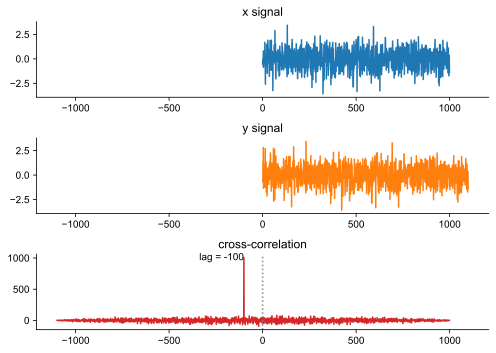

In [37]:
## compute cross-correlation
import numpy as np
from scipy import signal
rng = np.random.default_rng()
x = rng.standard_normal(1000)
y = np.concatenate([rng.standard_normal(100), x]) # y is the same as x, just added 100 random numbers at the beginning
correlation = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]

plt.figure(figsize=[7,5])
ax = plt.subplot(311)
plt.plot(x,c='C0')
plt.title('x signal')
sns.despine()

plt.subplot(312,sharex=ax)
plt.plot(y,c='C1')
plt.title('y signal')
sns.despine()

plt.subplot(313,sharex=ax)
plt.title('cross-correlation')
plt.plot(lags,correlation,c='C3')
plt.axvline(x=0,c='grey',ls=':')
plt.text(x=lag,y=np.max(correlation),s=f'lag = {lag}',va='center',ha='right')
sns.despine()

plt.tight_layout()

# data_concat = generate_cellclass_df(Celltype=Celltype,quantile=quantile,q='top')
# # plot_cellclass_binge_slow_trace(data_concat,Celltype,quantile,q='top')

# if 'apc' in Celltype:
#     plot_name = f'1_{Celltype}_neurontype_slow_binge_traces'
# elif 'gc' in Celltype:
#     plot_name = f'2_{Celltype}_neurontype_slow_binge_traces'
# elif 's2' in Celltype:
#     plot_name = f'2x_{Celltype}_neurontype_slow_binge_traces'
# else:
#     plot_name = f'3_{Celltype}_neurontype_slow_binge_traces'

# save_plot_pdf(plot_name)



(3906, 100)
(3906, 100)
(3906, 100)
(3906, 100)
milk pos: 9.81%
water pos: 14.62%
both pos: 1.66%
milk neg: 31.49%
milk non: 58.35%


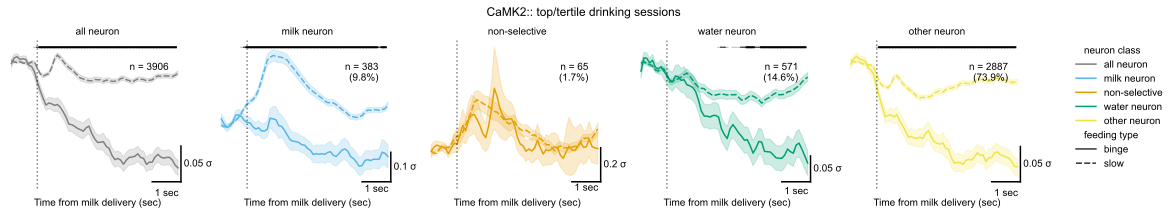

In [24]:
celltype_dict = {"apc_camk2":"CaMK2",
                 "apc_pv":"PV",
                 "apc_sst":"SST",
                 "gc":"GC",
                 "s2":"S2"}


## load auroc npy file for viz checking

file_folder = '/Users/hunglo/Documents/inscopix_csv/auroc_npy/'
extension = 'npy'
os.chdir(file_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
# result = [r for r in result if mouse_id in r]
result = [r for r in result if 'SNA' not in r] # exclude dopa & sero data
# result = [ r for r in result if 'water' not in r]
result = [ r for r in result if 'strawberry' in r or 'chocolate' in r or 'vanilla' in r]
# result = [ r for r in result if 'strawberry' in r ]
# result = [ r for r in result if 'water' in r] # check water responding neurons
# result = [ r for r in result if 'sucrose' in r]

# Celltype = 'GC'
# Celltype = 'S2'

Celltype = 'CaMK2'
# Celltype = 'SST'
# Celltype = 'PV'

result = [ r for r in result if Celltype in r]

auroc_slow_milk_concat = np.zeros([1,100])
auroc_slow_water_concat = np.zeros([1,100])
PETH_slow_milk_concat  = np.zeros([1,100])
PETH_binge_on_concat   = np.zeros([1,100])

# top_list = cohensd_table[]

def isin_tertile(cohensd_table,mouse_id,date,quantile=None,q=None):
    select_data = cohensd_table[cohensd_table['mouse_id']==mouse_id]
    select_data = select_data[select_data['date']==int(date.replace('.',''))]
    if select_data.shape[0]==0:
        # print('not in cohensd table, skip')
        return False
    if quantile is None:
        return True # don't perform tertile searhcing
    else:
        if q in select_data[quantile].values:
            return True
        else:
            return False

## select which tertile to look into

## quantile list: tertile, quartile, tertile_abs, quartile_abs, None
#### _abs means the absolute value of drinking events
## if setting quantile to None, then all behavioral sessions are selected, so q is not defined

# quantile = None
quantile = 'tertile'
# quantile = 'quartile'
# quantile = 'tertile_abs'
# quantile = 'quartile_abs'
q = 'top'

for r in result:
    # print(r)
    mouse_id = r.split('_')[1]
    date = r.split('_')[2]
    if not isin_tertile(cohensd_table,mouse_id,date,quantile=quantile,q=q): ## check if this recording is in a gvien tertile of drinking events
        # print('in bigger')
        continue
    ## find corresponding water PETH
    file_folder = '/Users/hunglo/Documents/inscopix_csv/auroc_npy/'
    extension = 'npy'
    os.chdir(file_folder)
    result_water = sorted(glob.glob('*.{}'.format(extension)))
    result_water = [rw for rw in result_water if mouse_id in rw and date in rw]
    result_water = [rw for rw in result_water if 'water' in rw]
    if len(result_water) ==0: # if there is no correponding file
        # print('no water auroc')
        continue
    # print(result_water)
    flavor = r.split('_')[4].split('.')[0]
    # print(flavor)

    file_path = os.path.join(file_folder,r)
    file_path_water = os.path.join(file_folder,result_water[0])

    # only load auroc & dff if there are both slow and binge eatings
    dff_path = get_npy_path(mouse_id,date)
    PETH_binge_on, PETH_binge_off, PETH_slow_milk, PETH_slow_water, PETH_lick_binge, PETH_lick_slow, PETH_pump_binge, PETH_pump_slow = load_npy(dff_path)
    flavor1 = dff_path.split('/')[-1].split('_')[3]
    flavor2 = dff_path.split('/')[-1].split('_')[4]
    PETH_avg = np.array([])
    PETH_avg_binge = np.array([])

    # if PETH_binge_on is not None and (PETH_slow_milk is not None or PETH_slow_water is not None):
    load_auroc = False
    if flavor == flavor1:
        if PETH_binge_on is not None:
            PETH_avg = np.mean(PETH_slow_milk,axis=1) # trial average slow
            PETH_avg_w = np.mean(PETH_slow_water,axis=1) # trial average water
            PETH_avg_binge = np.mean(PETH_binge_on,axis=1) # trial average binge
            load_auroc = True
        else:
            print('no binge event, skip')
            continue
    elif flavor == flavor2:
        if PETH_binge_on is not None:
            PETH_avg = np.mean(PETH_slow_water,axis=1) # trial average slow
            PETH_avg_w = np.mean(PETH_slow_milk,axis=1) # trial average water
            PETH_avg_binge = np.mean(PETH_binge_on,axis=1) # trial average binge
            load_auroc = True
        else:
            print('no binge event, skip')
            continue

    PETH_slow_milk_concat = np.vstack([PETH_slow_milk_concat,PETH_avg])
    PETH_binge_on_concat  = np.vstack([PETH_binge_on_concat,PETH_avg_binge])

    if load_auroc:
        auroc = np.load(file_path, allow_pickle=True)
        auroc_slow_milk_concat = np.vstack([auroc_slow_milk_concat,auroc])
        auroc_water = np.load(file_path_water, allow_pickle=True)
        auroc_slow_water_concat = np.vstack([auroc_slow_water_concat,auroc_water])

## remove the first zeros array
# auroc_slow_milk_concat = auroc_slow_milk_concat[~np.all(auroc_slow_milk_concat == 0, axis=1)] # remove first row
auroc_slow_milk_concat  = auroc_slow_milk_concat[1:,:]
auroc_slow_water_concat = auroc_slow_water_concat[1:,:]
PETH_slow_milk_concat   = PETH_slow_milk_concat[1:,:]
PETH_binge_on_concat    = PETH_binge_on_concat [1:,:]

straw_auroc = []
straw_auroc = auroc_slow_milk_concat.copy()
water_auroc = auroc_slow_water_concat.copy()
print(straw_auroc.shape)
print(water_auroc.shape)
print(PETH_slow_milk_concat.shape)
print(PETH_binge_on_concat.shape)

straw_idx_pos, straw_idx_neg, straw_idx_non = [],[],[]
straw_idx_pos, straw_idx_neg, straw_idx_non = cell_class(auroc=straw_auroc,window=2,threshold_sd=2)
water_idx_pos, water_idx_neg, water_idx_non = [],[],[]
water_idx_pos, water_idx_neg, water_idx_non = cell_class(auroc=water_auroc,window=2,threshold_sd=2)

both_idx = [idx for idx in straw_idx_pos if idx in water_idx_pos] # get both idx
straw_idx_pos = [idx for idx in straw_idx_pos if idx not in both_idx] # remove both idx from milk
water_idx_pos = [idx for idx in water_idx_pos if idx not in both_idx] # remove both idx from water

other_idx = [idx for idx in range(straw_auroc.shape[0]) if idx not in straw_idx_pos and idx not in water_idx_pos and idx not in both_idx]

print(f'milk pos: {len(straw_idx_pos)/straw_auroc.shape[0]*100:.2f}%')
print(f'water pos: {len(water_idx_pos)/straw_auroc.shape[0]*100:.2f}%')
print(f'both pos: {len(both_idx)/straw_auroc.shape[0]*100:.2f}%')

print(f'milk neg: {len(straw_idx_neg)/straw_auroc.shape[0]*100:.2f}%')
print(f'milk non: {len(straw_idx_non)/straw_auroc.shape[0]*100:.2f}%')

# respond_types = ['milk positive','milk negative','milk neutral','non-selective feeding']
# idx_list = [straw_idx_pos, straw_idx_neg, straw_idx_non,both_idx]

respond_types = ['milk neuron','non-selective','water neuron','other neuron']
idx_list = [straw_idx_pos,both_idx,water_idx_pos,other_idx]

feeding_types = ['slow','binge']
PETH_list = [PETH_slow_milk_concat,PETH_binge_on_concat]
data_concat = pd.DataFrame([])
for i in range(4):
    for j in range(2):
        data = np2df_long(PETH_list[j][idx_list[i]])
        # df = df.drop('column_name', axis=1)
        data = data.drop('index',axis=1)
        data['idx_cell']     = idx_list[i] * 100
        data['neuron class'] = respond_types[i]
        data['feeding type'] = feeding_types[j]
        data_concat = pd.concat([data_concat,data])
        data_concat = data_concat.reset_index(drop=True)

data_concat_duplicat = data_concat.copy()
data_concat_duplicat['neuron class'] = 'all neuron' # making a duplication of all neurons for plotting
data_concat = pd.concat([data_concat,data_concat_duplicat])
data_concat = data_concat.reset_index(drop=True)

# data_concat
## remove time < -1 sec, so we don't need to worry about the whatever is happening before baseline (previous drinking events)
data_concat = data_concat[data_concat['Time (sec)']>-1]
# data_concat = data_concat[data_concat['Time (sec)']<4]

total_neuron_num = len(data_concat['idx_cell'].unique())
def deco_sns(data, **kws):
    n = len(data['idx_cell'].unique())
    ax = plt.gca()
    ax.axvline(x=0,ls=':',color='k',alpha=0.5)
    if n == total_neuron_num:
        ax.text(.9,.85,f'n = {n}',transform=ax.transAxes,ha='right',va='top') # annotate n number, no % for all neurons
    else:
        ax.text(.9,.85,f'n = {n}\n({round(n/total_neuron_num*100,1)}%)',transform=ax.transAxes,ha='right',va='top') # annotate n number

def deco_stats(data,**kws):
    t_sign_05 = get_qvalue(data,threshold_q=0.05)
    t_sign_01 = get_qvalue(data,threshold_q=0.01)
    t_sign_001 = get_qvalue(data,threshold_q=0.001)
    ax = plt.gca()
    ymax = ax.get_ylim()[1]
    for t in t_sign_05:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=0.3,lw=1)
    for t in t_sign_01:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=0.6,lw=1.5)
    for t in t_sign_001:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=1,lw=2)
    ax.set_xlim(xmin=-1)

def get_qvalue(data, threshold_q=0.05):
    from scipy import stats
    from statsmodels.stats.multitest import fdrcorrection
    # threshold_q=threshold_q/4 # in case we need to account for 4 clusters of neurons
    t_sign = []
    p_concat = []
    slow_data = data[data['feeding type']=='slow']
    binge_data = data[data['feeding type']=='binge']
    for t in data['Time (sec)'].unique():
        slow_value  = slow_data[slow_data['Time (sec)']==t]['zs-dff'].values
        binge_value = binge_data[binge_data['Time (sec)']==t]['zs-dff'].values
        p_val = stats.ttest_ind(slow_value, binge_value, equal_var=False)[1]
        p_concat.append(p_val)

    rejected, q_value = fdrcorrection(np.array(p_concat),method='poscorr')
    adj_p_sign_idx = q_value<threshold_q
    t_scale = np.arange(-1,4.9,0.1)
    t_sign = t_scale[adj_p_sign_idx]

    return t_sign

def deco_scale(data,**kws):
    ax = plt.gca()
    yticks = ax.get_yticks()
    yunit = yticks[1]-yticks[0]
    yunit = round(yunit,2)
    # if yunit >0.1:
    #     yunit=0.1 # shrink it?
    ylims = ax.get_ylim()
    y_bottom,y_top = ylims[0], ylims[0]+yunit
    ax.plot([5,5],[y_bottom,y_top],c='k')
    ax.text(5.1,y_bottom+yunit/2,f'{yunit} \u03C3',va='center',ha='left') # \u03C3 is sigma=sd
    ax.plot([4,5],[y_bottom,y_bottom],c='k')
    ax.text(4.5,y_bottom-0.01,'1 sec',ha='center',va='top')
    # ax.set_axis_off()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.set_xlabel('Time from milk delivery (sec)',labelpad=10)
    sns.despine(bottom=True,left=True,ax=ax)

hue_num = 5

n_boot = 100 # for fast plotting
n_boot = 1000 # default

g = sns.relplot(data=data_concat,x='Time (sec)',y='zs-dff', 
                col='neuron class',col_order=['all neuron','milk neuron','non-selective','water neuron','other neuron'],
                hue='neuron class',hue_order=['all neuron','milk neuron','non-selective','water neuron','other neuron'],palette=my_color_map_grey[0:hue_num],
                style='feeding type',style_order=['binge','slow'],
                kind="line",height=3,aspect=1,n_boot=n_boot,errorbar='se',
                facet_kws={'sharey': False, 'sharex': True},)#,gridspec_kws={"wspace":0.4})
g.map_dataframe(deco_sns)
g.map_dataframe(deco_stats)
g.map_dataframe(deco_scale)
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=.825, wspace=0.18)
g.fig.suptitle([f'{Celltype}:: {q}/{quantile} drinking sessions' if quantile is not None else f'{Celltype} All behavioral quantiles'][0])
# plt.show()

plot_name = f'1_{Celltype}_neurontype_slow_binge_traces'
save_plot_pdf(plot_name)

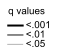

In [74]:
## plot for testing example
def deco_stats(data,**kws):
    t_sign_05 = get_qvalue(data,threshold_q=0.05)
    t_sign_01 = get_qvalue(data,threshold_q=0.01)
    t_sign_001 = get_qvalue(data,threshold_q=0.001)
    ax = plt.gca()
    ymax = ax.get_ylim()[1]
    for t in t_sign_05:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=0.3,lw=1)
    for t in t_sign_01:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=0.6,lw=1.5)
    for t in t_sign_001:
        ax.plot([t-0.025,t+0.025],[ymax*0.95,ymax*0.95],color='k',alpha=1,lw=2)
    ax.set_xlim(xmin=-1)

fig, ax = plt.subplots(figsize=[0.35,0.5])
ax.plot([0,1],[0,0],color='k',alpha=0.3,lw=1)
ax.plot([0,1],[1,1],color='k',alpha=0.6,lw=1.5)
ax.plot([0,1],[2,2],color='k',alpha=1,lw=2)

ax.set_ylim(ymax=2.75)
ax.set_xlim([0,1.25])
ax.text(1.2,0,'<.05',ha='left',va='center')
ax.text(1.2,1,'<.01',ha='left',va='center')
ax.text(1.2,2,'<.001',ha='left',va='center')
ax.text(1.25,3,'q values',ha='center',va='bottom')

sns.despine(bottom=True,left=True)
# ax.set_title('stats: q')
ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()
plot_name = '1_p_scale'
save_plot_pdf(plot_name)


In [204]:
# 

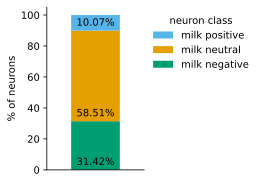

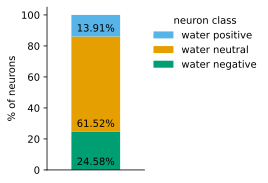

In [68]:
## make a new bar graph for milk & water responding neurons

def idx2df(straw_idx_pos, straw_idx_non, straw_idx_neg, label= 'milk'):

  labels = [f'{label} positive', f'{label} neutral', f'{label} negative']
  sizes = [len(straw_idx_pos),
           len(straw_idx_non),
           len(straw_idx_neg)]
  sizes /= np.sum(sizes)
  sizes *= 100 # make 100%

  cell_num_list_T = pd.DataFrame(sizes[::-1]).T # reverse order
  cell_num_list_T.rename({2: labels[0], 1: labels[1],0: labels[2]}, axis=1, inplace=True)

  return cell_num_list_T

def plot_bargraph(cell_num_list_T):
  fig, ax1 = plt.subplots(figsize=[1.75,3])
  class_num = cell_num_list_T.shape[1]
  cell_num_list_T.plot(kind='bar',stacked=True,color=my_color_map[class_num-1::-1],ax=ax1)
  ax1.set_xticks([])
  ax1.legend()  # reverse both handles and labels
  handles, labels = plt.gca().get_legend_handles_labels()
  for idx,x in enumerate(cell_num_list_T.iloc[0,:]):
    steps = [0, *cell_num_list_T.iloc[0,:].values.cumsum()]
    text = f'{round(x,2):.2f}'
    # if idx==2:
    #   ax1.text(0.425,steps[idx],text+'%',ha='center',va='center')
    # else: 
    ax1.text(0,steps[idx]+5,text+'%',ha='center',va='center')
      
  order = list(range(class_num))[::-1]
  ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper left',bbox_to_anchor=(1.0, 1), frameon=False,title='neuron class')
  plt.ylabel('% of neurons')
  sns.despine()
  plt.show()

cell_num_list_T = idx2df(straw_idx_pos, straw_idx_non, straw_idx_neg, label= 'milk')
plot_bargraph(cell_num_list_T)

cell_num_list_T = idx2df(water_idx_pos, water_idx_non, water_idx_neg, label= 'water')
plot_bargraph(cell_num_list_T)

# cell_num_list_T.shape[1]

In [69]:
## make idx lists to df as milk/water as columns and each row is each neuron and their identities

def idx2list(straw_idx_pos, straw_idx_non, straw_idx_neg):
    neuron_num = len(straw_idx_pos)+len(straw_idx_non)+len(straw_idx_neg)
    print(neuron_num)
    num_list = list(range(neuron_num))
    milk_list = []
    for idx in num_list:
        if idx in straw_idx_pos:
            milk_list.append('positive')
        elif idx in straw_idx_neg:
            milk_list.append('negative')
        elif idx in straw_idx_non:
            milk_list.append('neutral')

    return milk_list

milk_list = idx2list(straw_idx_pos, straw_idx_non, straw_idx_neg)
milk_list

water_list = idx2list(water_idx_pos, water_idx_non, water_idx_neg)

neuron_class_df = pd.DataFrame([milk_list,water_list],index=['milk','water']).T
neuron_class_df


3823
3833


milk     water
0      neutral   neutral
1      neutral   neutral
2      neutral  negative
3     negative   neutral
4     negative   neutral
...        ...       ...
3761      None  negative
3762      None  negative
3763      None   neutral
3764      None   neutral
3765      None   neutral

[3766 rows x 2 columns]

In [23]:
# # Sankey's diagram
# # from pySankeyBeta import sankey
# from pySankey import sankey

# sankey(neuron_class_df['milk'], neuron_class_df['water'])


In [18]:
## function for calculate cohen's d on binging for all recordings

df_estimate_concat = pd.DataFrame([])

# result = [r for r in result if 'DSC018623' in r]

camk2_mouse_id_list = ['BES0224','BES0225','BES0233','BES0421','BES0424','BES0427','DSC016028','DSC019409']
gc_mouse_id_list = ['DSC018623','DSC018624','DSC017911']
pv_mouse_id_list = ['DSC012019','DSC012487','DSC016006']
sst_mouse_id_list = ['DSC012972','DSC013919','DSC016066' ]
# for mouse_id in camk2_mouse_id_list:
# for mouse_id in gc_mouse_id_list:
# for mouse_id in pv_mouse_id_list:
for mouse_id in sst_mouse_id_list:
    print(f'\nnow process: {mouse_id}')
    # mouse_id = 'BES0224'
    file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
    extension = 'npy'
    os.chdir(file_folder)
    result = sorted(glob.glob('*.{}'.format(extension)))
    result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa data
    result = [r for r in result if mouse_id in r]

    estimation_list = []
    date_list = []
    triton_list = []
    fasting_list = []
    milk_consumption_list = []

    triton_mouse_list = ['BES0421','DSC016028','DSC019409']

    if mouse_id in triton_mouse_list:
        triton_dates = ['211006','211007','211008','211009','211011',
                        '220126','220127','220128','220129','220131','220201','220202','220203','220204','220207','220208',
                        '221102','221103','221104','221105']
    else:
        triton_dates = []

    for i in result[:]:
        datenodot = i.split('_')[1].replace('.','')
        print(datenodot)

        file_path = os.path.join(file_folder,i)
        PETH_binge_on, _,_,_ = load_npy(file_path=file_path) # note date will be print from here
        if PETH_binge_on is None:
            print('no binges, skip')
            continue
        else:
            print(PETH_binge_on.shape)
            if PETH_binge_on.shape[0]<3: # too few cells
                print('too few cells, skip')
                continue
            else:
                date_list.append(datenodot)
                if datenodot in triton_dates:
                    triton_list.append(True)
                else:
                    triton_list.append(False)
                if 'severe' in i:
                    fasting_list.append(True)
                else:
                    fasting_list.append(False)

                ## convert np array to pd.DataFrame
                df_binge_auc = pd.DataFrame([np.trapz(PETH_binge_on[:,:,10:50].mean(axis=(1)),dx=0.1),
                                            np.trapz(PETH_binge_on[:,:,50:90].mean(axis=(1)),dx=0.1),])
                df_binge_auc = df_binge_auc.T
                                            #  columns=['Pre-binge-on','Post-binge-on'])
                df_binge_auc.rename(columns={0:'Pre-binge-on',1:'Post-binge-on'},inplace=True)
                df_binge_auc = df_binge_auc.reset_index()
                df_binge_auc.rename(columns={'index':'ID'},inplace=True)
                df_binge_auc

                ## Save estimation object in dict
                estimation_dict = {}
                two_groups_paired = dabest.load(df_binge_auc, idx=("Pre-binge-on","Post-binge-on"),paired=True, id_col="ID")
                estimate = two_groups_paired.cohens_d.results

                estimation_dict[i] = estimate
                estimation_list.append(estimate['difference'].to_numpy()[0])
                # print(f'>AUC cohens_d: {estimation_list[-1]:.2f}')
                Phenosys_folder = '/Users/hunglo/Documents/inscopix_csv/Phenosys_csv/'
                extension = 'csv'
                os.chdir(Phenosys_folder)
                result_pheno = sorted(glob.glob('*.{}'.format(extension)))
                result_pheno = [r for r in result_pheno if mouse_id in r]
                result_pheno = [r for r in result_pheno if i.split('_')[1] in r]
                # print(result_pheno)
                # result_pheno
                file_path_pheno = os.path.join(Phenosys_folder,result_pheno[0])
                L1,P1,P2,PAll = binge.load_phenosys(file_path_pheno)
                milk_consumption = len(PAll)
                # print(milk_consumption)
                milk_consumption_list.append(milk_consumption)            

    df_estimate = pd.DataFrame([date_list,estimation_list]).T
    df_estimate.rename(columns={0:'date',1:'cohens_d'}, inplace=True)
    df_estimate['cohens_d'] = df_estimate['cohens_d'].astype('float')
    df_estimate['mouse_id'] = mouse_id
    df_estimate['anosmic'] = triton_list
    df_estimate['fasted'] = fasting_list
    df_estimate['milk_consumption'] = milk_consumption_list

    df_estimate_concat = pd.concat([df_estimate_concat,df_estimate],axis=0)
df_estimate_concat['anosmic'] = df_estimate_concat['anosmic'].astype('bool')
df_estimate_concat['fasted'] = df_estimate_concat['fasted'].astype('bool')

# df_estimate_concat.to_csv(f'/Users/hunglo/Documents/inscopix_csv/processed_csv/apc_camk2_cohensd.csv',index=False)
# df_estimate_concat.to_csv(f'/Users/hunglo/Documents/inscopix_csv/processed_csv/gc_cohensd.csv',index=False)
# df_estimate_concat.to_csv(f'/Users/hunglo/Documents/inscopix_csv/processed_csv/apc_pv_cohensd.csv',index=False)
df_estimate_concat.to_csv(f'/Users/hunglo/Documents/inscopix_csv/processed_csv/apc_sst_cohensd.csv',index=False)
print('\nDone')
# for key in estimation_dict.keys():
#     print(key)
#     print(estimation_dict[key]['difference'])
# plt.plot()


now process: DSC012972
210118
(16, 7, 100)
210119
(15, 6, 100)
210120
(22, 8, 100)
210122
(20, 9, 100)
210123
(29, 3, 100)
210124
(32, 3, 100)
210125
(37, 5, 100)
210126
(38, 5, 100)
210127
(45, 4, 100)
210128
(44, 5, 100)
210129
(40, 6, 100)
210130
(49, 3, 100)
210202
(52, 5, 100)
210203
(58, 3, 100)
210204
(44, 4, 100)
210208
(53, 2, 100)
210209
(36, 3, 100)
210210
(49, 5, 100)
210211
(44, 14, 100)
210215
(74, 3, 100)
210216
(47, 4, 100)

now process: DSC013919
210419
(5, 1, 100)
210420
(4, 5, 100)
210421
(8, 5, 100)
210422
(4, 6, 100)
210423
(4, 4, 100)
210426
(6, 6, 100)
210428
(7, 7, 100)
210429
(5, 2, 100)
210430
(6, 4, 100)
210503
(2, 3, 100)
too few cells, skip
210504
(2, 10, 100)
too few cells, skip
210505
(4, 4, 100)
210506
(4, 3, 100)
210507
(3, 3, 100)
210510
(4, 4, 100)
210511
(1, 4, 100)
too few cells, skip
210517
(1, 4, 100)
too few cells, skip
210518
(3, 7, 100)

now process: DSC016066

Done


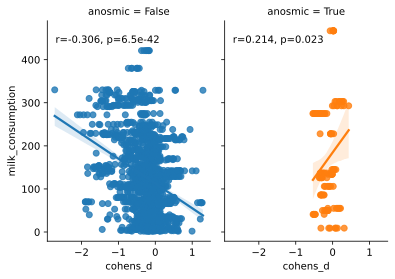

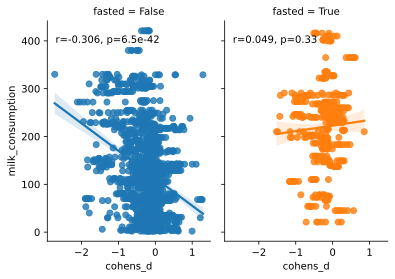

In [70]:
df_estimate_concat

import scipy as sp
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['cohens_d'], data['milk_consumption'])
    ax = plt.gca()
    ax.text(.05, .9, 'r={:.3f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

data = df_estimate_concat[df_estimate_concat['fasted'] == False]
g = sns.lmplot(data=data,x='cohens_d',y='milk_consumption',col='anosmic',height=4,aspect=0.7,hue='anosmic')
g.map_dataframe(annotate)
plt.show()

data = df_estimate_concat[df_estimate_concat['anosmic'] == False]
g = sns.lmplot(data=data,x='cohens_d',y='milk_consumption',col='fasted',height=4,aspect=0.7,hue='fasted')
g.map_dataframe(annotate)
plt.show()

# plt.ylim(ymin=-50,ymax=500)

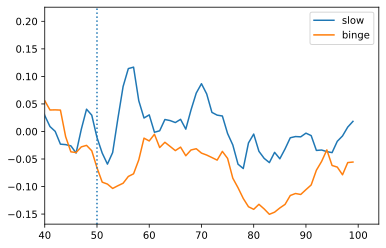

In [71]:
plt.plot(PETH_slow_milk.mean(axis=(0,1)),label='slow')
# plt.plot(PETH_slow_water.mean(axis=(0,1)))
plt.plot(PETH_binge_on.mean(axis=(0,1)),label='binge')
# plt.plot(PETH_binge_off.mean(axis=(0,1)))
plt.xlim(xmin=40)
plt.legend()
plt.axvline(x=50,ls=':')
# plt.ylim(ymin=-0.15)

In [ ]:
baseline_window = 1
threshold_sd = 3.5
auroc = cal_auroc(PETH_slow_milk[:], baseline_window=baseline_window)
idx_positive = cell_class(auroc,window=2,threshold_sd=threshold_sd)
print(f'-- {round(len(idx_positive)/auroc.shape[0]*100,2)}%')

In [ ]:
t_scale = np.arange(-5,5,0.1)
plt.plot(t_scale,PETH_slow_milk[idx_positive].mean(axis=(0,1)),c=my_color_map[0],alpha=0.5)
# plt.plot(PETH_slow_water.mean(axis=(0,1)))
plt.plot(t_scale,PETH_binge_on[idx_positive].mean(axis=(0,1)),c=my_color_map[0])
# plt.plot(PETH_binge_off.mean(axis=(0,1)))
plt.xlim(xmin=-1)
plt.axvline(x=0,ls=':',c='k')

In [ ]:
baseline_window = 1
threshold_sd = 3.5
auroc_binge = cal_auroc(PETH_binge_on[:], baseline_window=baseline_window)
idx_positive_binge = cell_class(auroc_binge,window=2,threshold_sd=threshold_sd)
print(f'-- {round(len(idx_positive_binge)/auroc_binge.shape[0]*100,2)}%')


In [ ]:
plt.plot(PETH_slow_milk[idx_positive_binge].mean(axis=(0,1)),c=my_color_map[1],alpha=0.5)
plt.plot(PETH_binge_on[idx_positive_binge].mean(axis=(0,1)),c=my_color_map[1])
plt.plot(PETH_slow_milk[idx_positive].mean(axis=(0,1)),c=my_color_map[0],alpha=0.5)
plt.plot(PETH_binge_on[idx_positive].mean(axis=(0,1)),c=my_color_map[0])
plt.xlim(xmin=40)
# plt.ylim(ymin=-0.2)
plt.axvline(x=50,ls=':')

In [ ]:
isort = np.argsort(-auroc_binge[:,50:70].mean(axis=1))
isort = np.argsort(-auroc[:,50:70].mean(axis=1))
plt.imshow(auroc[isort,:],aspect='auto',vmin=0.2,vmax=0.8,cmap='bwr')
plt.show()
plt.imshow(auroc_binge[isort,:],aspect='auto',vmin=0.2,vmax=0.8,cmap='bwr')

In [ ]:
# plt.imshow(PETH_concat,aspect='auto')

In [ ]:
### try a quick PCA here?

# PSTH_milk_concat
PETH_concat = np.concatenate([PETH_slow_milk[:,:,40:].mean(axis=1),PETH_binge_on[:,:,40:].mean(axis=1)],axis=1)
# PETH_concat = np.concatenate([PETH_slow_milk[:,:,40:].mean(axis=1),PETH_slow_water[:,:,40:].mean(axis=1),PETH_binge_on[:,:,40:].mean(axis=1)],axis=1)
# PETH_concat = np.concatenate([PETH_slow_milk[:,:,40:].mean(axis=1),PETH_slow_water[:,:,40:].mean(axis=1)],axis=1)

PETH_concat.shape

## PCA
from sklearn.decomposition import PCA

S = PETH_concat.copy()
# S = auROC_concat.copy()

model = PCA(n_components=np.min(S.shape))
# model = PCA(n_components=20)

model.fit(S)

# plot some components
X = model.components_
Y = model.transform(X)
plt.figure(figsize=(6, 4))
# plt.subplot(1, 2, 1)
for j in range(5):
    plt.plot(X[j] - j * 0.1, linestyle="-", linewidth=1, marker="",label=j)
plt.legend()
# plt.subplot(1, 2, 2)
# for j in range(5):
#     plt.plot(X[j, 10:40] - j * 0.05, linestyle="-", linewidth=1, marker="")
plt.tight_layout()
# plt.savefig('/Users/hunglo/Desktop/Lab_seminar_figs/PCA_PC5.png',dpi=600)
plt.show()

# loadings = model.components_.T * np.sqrt(model.explained_variance_)

# loading_matrix = pd.DataFrame(loadings)
# loading_matrix

In [ ]:


# pc_values = pc_df['PC1'][isort].values
# plt.plot(PETH_slow_milk[isort,:,:][pc_values>0.8].mean(axis=(0,1)))
# plt.plot(PETH_binge_on[isort,:,:][pc_values>0.8].mean(axis=(0,1)))
# plt.xlim(xmin=40)
# plt.axvline(x=50,ls=":")

In [ ]:
# i=0
# isort = np.argsort(-pc_df[f'PC{i+1}'].values)
# pc_values = pc_df[f'PC{i+1}'][isort].values
# for j in range(30):
#     plt.plot(PETH_binge_on[isort][j].mean(axis=0)-j)
# plt.show()
# for j in range(30):
#     plt.plot(PETH_slow_milk[isort][j].mean(axis=0)-j)
# plt.show()

In [ ]:
## Plot cell weights against PCs.
pc_df = pd.DataFrame()
for i in range(50):
    pc_df[i] = S @ model.components_[i]
    pc_df[i] = pc_df[i]/np.max(np.abs(pc_df[i]))  # Normalize or not
pc_df

col_names = [f'PC{i+1}' for i in range(pc_df.shape[1])]
col_dict = {}
for i in range(pc_df.shape[1]):
    col_dict[i]=col_names[i]

pc_df.rename(columns=col_dict,inplace=True)

weight_threshold = 0.2

for i in range(5):
    isort = np.argsort(-pc_df[f'PC{i+1}'].values)
    pc_values = pc_df[f'PC{i+1}'][isort].values
    plt.plot(PETH_slow_milk[isort,:,:][pc_values>weight_threshold].mean(axis=(0,1)),label='slow milk')
    plt.plot(PETH_binge_on[isort,:,:][pc_values>weight_threshold].mean(axis=(0,1)),label='binge milk')
    plt.legend(title=f'n={sum(pc_values>weight_threshold)}')
    plt.xlim(xmin=40)
    plt.title(f'PC{i+1} top coefficient cells')
    plt.axvline(x=50,ls=":")
    sns.despine()
    plt.show()

# isort = np.argsort(-pc_df['PC2'].values)
# # plt.plot(pc_df.iloc[isort]['PC1'].values)

# plt.imshow(pc_df.iloc[isort,0:5][0:],aspect='auto',interpolation='None')
# plt.colorbar()


In [ ]:
for i in range(5):
    plt.plot(X[i][:60],label='slow milk',c=my_color_map[i],alpha=0.5,lw=2)
    # plt.plot(X[i][60:120],label='slow water',c=my_color_map[1],alpha=0.5,lw=2)
    plt.plot(X[i][60:],label='binge',c=my_color_map[i],alpha=1,lw=2)
    plt.legend()
    plt.title(f'PC{i+1}')
    plt.axvline(x=10,ls=':')
    sns.despine()
    plt.show()


In [ ]:
#@title Variance explained
## Scree plot

cum_vx = np.cumsum(model.explained_variance_ratio_)
num_pc_90 = len(cum_vx[cum_vx<0.9])+1

fig, [ax0, ax1] = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))
ax0.plot(
    np.arange(len(model.explained_variance_ratio_)) + 1,
    model.explained_variance_ratio_,
    linewidth=2,
)
ax0.set_title("Scree plot", fontsize=16)
ax0.set_xlabel("PC number", fontsize=14)
ax0.set_ylabel("Variance explained", fontsize=14)
# ax0.vlines(ymin=0, ymax=np.max(model.explained_variance_ratio_), x=num_pc_90, linestyles=":", linewidth=2)
ax0.axvline(x=num_pc_90, linestyle=":", linewidth=2,label=f"90% explained\nwith top {num_pc_90} PCs")
ax0.legend(loc=1,frameon=False)

ax1.plot(
    np.arange(len(model.explained_variance_ratio_)) + 1,
    np.cumsum(model.explained_variance_ratio_),
    linewidth=2,
)
ax1.set_title("Scree plot (cum.)", fontsize=16)
ax1.set_xlabel("PC number", fontsize=14)
# ax1.set_ylabel("Variance explained", fontsize=14)
# ax1.vlines(ymin=np.max(model.explained_variance_ratio_), ymax=1, x=num_pc_90, linestyles=":", linewidth=2,label='90% explained')
ax1.axvline(x=num_pc_90, linestyle=":", linewidth=2,label=f"90% explained\nwith top {num_pc_90} PCs")

ax1.legend(loc=4,frameon=False)
sns.despine()

plt.tight_layout()
plt.show()

print(
    "Variance explained when PC="+str(num_pc_90)+": \n"
    + str(np.cumsum(model.explained_variance_ratio_)[num_pc_90-1])
)

In [ ]:
plt.plot(X[0][:60],X[1][:60],label='slow')
plt.plot(X[0][60:],X[1][60:],label='binge')
plt.legend()

In [ ]:
### SVM just for fun

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import roc_auc_score
## new classifier with pipeline w/ scaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [ ]:
## function for classifer
def svm_rfc(PETH_slow_milk,PETH_binge_on,fold=2,shuffle=False,repeat=100):
    # initiate score list
    score_svm_avg_100 = []
    auroc_svm_avg_100 = []
    score_rfc_avg_100 = []

    for j in range(repeat):
        trial_num = PETH_binge_on.shape[1]
        # trial_num = PETH_slow_milk.shape[1]
        # trial_num = 10
        picked = sorted(np.random.choice(PETH_slow_milk.shape[1],trial_num,replace=False))

        # sorted(np.random.choice(b_lick_p1_flatten,len(s_lick_p1_flatten),replace=False))
        ## auc
        milk_max  = pd.DataFrame(np.trapz(PETH_slow_milk[:,picked,50:80], dx=0.1).T)
        # milk_max  = pd.DataFrame(PETH_slow_milk[:,picked,50:80].mean(axis=2).T)
        milk_max['Binge'] = 0
        binge_max  = pd.DataFrame(np.trapz(PETH_binge_on[:,:,50:80], dx=0.1).T)
        # binge_max = pd.DataFrame(PETH_binge_on[:,:,50:80].mean(axis=2).T)
        binge_max['Binge'] = 1

        design_matrix = pd.concat([milk_max,binge_max])
        design_matrix = design_matrix.sample(frac=1).reset_index(drop=True)
        if shuffle:
            design_matrix['Binge'] = design_matrix['Binge'].sample(frac=1).reset_index(drop=True) ## shuffling for controls

        ## SVM & RFC
        # Set x & y
        X = design_matrix.iloc[:,:-1]
        y = design_matrix.iloc[:,-1]

        # CV
        cv = StratifiedKFold(n_splits=fold)
        svc = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True))
        rfc = make_pipeline(StandardScaler(), RandomForestClassifier())

        score_svm = []
        auc_svm = []
        score_rfc = []
        auc_rfc = []

        # for i,(train, test) in enumerate(loo.split(X)):

        for i, (train, test) in enumerate(cv.split(X, y)):
            svc.fit(X.iloc[train], y.iloc[train])
            rfc.fit(X.iloc[train], y.iloc[train])
            y_score = svc.predict(X.iloc[test])

            score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
            auc_svm.append(roc_auc_score(y.iloc[test],y_score))
            score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))

        score_svm_avg_100.append(np.mean(score_svm))
        auroc_svm_avg_100.append(np.mean(auc_svm))
        score_rfc_avg_100.append(np.mean(score_rfc))
        if j % 10 ==0:
            print(f'Trial {j}')
        # print('Trial:',j+1, '\n',np.mean(score_svm),'\n', np.mean(score_rfc))

    return score_svm_avg_100,score_rfc_avg_100,auroc_svm_avg_100

def svm_rfc_plot(score_svm_avg_100,score_rfc_avg_100):
    plt.figure(figsize=[3,4])
    df_temp = pd.DataFrame([])
    df_temp['svm'] = score_svm_avg_100
    df_temp['rfc'] = score_rfc_avg_100
    df_temp = df_temp.melt(var_name='classifier',value_name='accuracy')

    sns.stripplot(data=df_temp,x='classifier',y='accuracy',hue='classifier',dodge=0.25,alpha=0.4)
    sns.pointplot(data=df_temp,x='classifier',y='accuracy',markers="d",errorbar='sd',join=False,hue='classifier')
    # sns.swarmplot(pd.DataFrame(np.hstack([score_svm_avg_100,score_rfc_avg_100])))
    plt.legend([],[], frameon=False)
    plt.text(0,np.mean(score_svm_avg_100),round(np.mean(score_svm_avg_100),2),ha='left',va='bottom')
    plt.text(1,np.mean(score_rfc_avg_100),round(np.mean(score_rfc_avg_100),2),ha='left',va='bottom')
    plt.axhline(y=0.5,ls=':',c='k')
    sns.despine()
    plt.tight_layout()
    plt.show()


score_svm_avg_100,score_rfc_avg_100,auroc_svm_avg_100 = svm_rfc(PETH_slow_milk,PETH_binge_on,fold=2,shuffle=False,repeat=100)
# score_svm_avg_100_sh,score_rfc_avg_100_sh,auroc_svm_avg_100_sh = svm_rfc(PETH_slow_milk,PETH_binge_on,fold=2,shuffle=True,repeat=100)

svm_rfc_plot(score_svm_avg_100,score_rfc_avg_100)
# svm_rfc_plot(score_svm_avg_100_sh,score_rfc_avg_100_sh)


In [ ]:
# initiate score list
score_svm_avg_100 = []
score_rfc_avg_100 = []

for j in range(100):
    trial_num = PETH_binge_on.shape[1]
    # trial_num = PETH_slow_milk.shape[1]
    # trial_num = 10
    picked = sorted(np.random.choice(PETH_slow_milk.shape[1],trial_num,replace=False))

    # sorted(np.random.choice(b_lick_p1_flatten,len(s_lick_p1_flatten),replace=False))
    ## auc
    milk_max  = pd.DataFrame(np.trapz(PETH_slow_milk[:,picked,50:80], dx=0.1).T)
    # milk_max  = pd.DataFrame(PETH_slow_milk[:,picked,50:80].mean(axis=2).T)
    milk_max['Binge'] = 0
    binge_max  = pd.DataFrame(np.trapz(PETH_binge_on[:,:,50:80], dx=0.1).T)
    # binge_max = pd.DataFrame(PETH_binge_on[:,:,50:80].mean(axis=2).T)
    binge_max['Binge'] = 1

    design_matrix = pd.concat([milk_max,binge_max])
    design_matrix = design_matrix.sample(frac=1).reset_index(drop=True)
    # design_matrix['Binge'] = design_matrix['Binge'].sample(frac=1).reset_index(drop=True) ## shuffling for controls

    ## SVM & RFC
    # Set x & y
    X = design_matrix.iloc[:,:-1]
    y = design_matrix.iloc[:,-1]

    # CV
    cv = StratifiedKFold(n_splits=int(X.shape[0]/2))
    # cv = StratifiedShuffleSplit(n_splits=2)
    # loo = LeaveOneOut()
    # svc = svm.SVC(kernel='linear', probability=True)
    svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    rfc = make_pipeline(StandardScaler(), RandomForestClassifier())
    # rfc = RandomForestClassifier()

    score_svm = []
    auc_svm = []
    score_rfc = []
    auc_rfc = []

    # for i,(train, test) in enumerate(loo.split(X)):

    for i, (train, test) in enumerate(cv.split(X, y)):
        svc.fit(X.iloc[train], y.iloc[train])
        rfc.fit(X.iloc[train], y.iloc[train])

        score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
        score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))

    score_svm_avg_100.append(np.mean(score_svm))
    score_rfc_avg_100.append(np.mean(score_rfc))
    if j % 10 ==0:
        print(f'Trial {j}')
    # print('Trial:',j+1, '\n',np.mean(score_svm),'\n', np.mean(score_rfc))
plt.figure(figsize=[3,4])
# plt.bar(['svm','rfc'],[np.mean(score_svm_avg_100),np.mean(score_rfc_avg_100)],color='grey')
# plt.plot(np.zeros(len(score_svm_avg_100)),score_svm_avg_100,marker='.',ls='',c='k')
# plt.plot(np.ones(len(score_rfc_avg_100)),score_rfc_avg_100,marker='.',ls='',c='k')
df_temp = pd.DataFrame([])
df_temp['svm'] = score_svm_avg_100
df_temp['rfc'] = score_rfc_avg_100
df_temp = df_temp.melt(var_name='classifier',value_name='accuracy')

# sns.stripplot(data=df_temp,x='classifier',y='accuracy',hue='classifier',dodge=0.25,alpha=0.4)
sns.pointplot(data=df_temp,x='classifier',y='accuracy',markers="d",errorbar='sd',join=False,hue='classifier')
# sns.swarmplot(pd.DataFrame(np.hstack([score_svm_avg_100,score_rfc_avg_100])))
plt.legend([],[], frameon=False)
plt.text(0,np.mean(score_svm_avg_100)+0.05,round(np.mean(score_svm_avg_100),2),ha='center')
plt.text(1,np.mean(score_rfc_avg_100)+0.05,round(np.mean(score_rfc_avg_100),2),ha='center')
plt.axhline(y=0.5,ls=':',c='k')
sns.despine()
plt.tight_layout()
print(round(np.mean(score_svm_avg_100),2), round(np.mean(score_rfc_avg_100),2))

In [ ]:
## transform array to pd dataframe
slow vs binge in GC

0.43 / 0.33 (match trials, max in 2 sec)
0.37 / 0.33 (match trials, max in 3 sec)

0.47 / 0.33 (match trials, mean in 2 sec)
0.47 / 0.33 (match trials, mean in 3 sec)

0.34 / 0.34 (match trials, mean in 2 sec before stim)

## auc
0.44 / 0.33 (match trials, auc, dx=0.1 in 2 sec)
0.45 / 0.33 (match trials, auc, dx=0.1 in 3 sec)

slow vs binge in aPC
0.51 / 0.59 (match trials, auc, dx=0.1 in 3 sec)
0.53 / 0.57 (match trials, auc, dx=0.1 in 2 sec)
0.52 / 0.58 (match trials, auc, dx=0.1 in 1-3 sec)

0.52 / 0.57 (match trials, mean in 3 sec)

0.76 / 0.84

In [ ]:
## slow milk vs water
# initiate score list
score_svm_avg_100 = []
score_rfc_avg_100 = []

for j in range(100):
    trial_num = PETH_slow_water.shape[1]
    # trial_num = PETH_slow_milk.shape[1]
    # trial_num = 10
    picked = sorted(np.random.choice(PETH_slow_milk.shape[1],trial_num,replace=False))

    # sorted(np.random.choice(b_lick_p1_flatten,len(s_lick_p1_flatten),replace=False))
    ## auc
    # milk_max  = pd.DataFrame(np.trapz(PETH_slow_milk[:,picked,60:80], dx=0.1).T)
    milk_max  = pd.DataFrame(PETH_slow_milk[:,picked,50:80].mean(axis=2).T)
    # milk_max['Binge'] = 0
    milk_max['milk']  = 1
    # binge_max  = pd.DataFrame(np.trapz(PETH_binge_on[:,:,60:80], dx=0.1).T)
    binge_max = pd.DataFrame(PETH_slow_water[:,:,50:80].mean(axis=2).T)
    # binge_max['Binge'] = 1
    binge_max['milk'] = 0

    design_matrix = pd.concat([milk_max,binge_max])
    design_matrix = design_matrix.sample(frac=1).reset_index(drop=True)
    # design_matrix['Binge'] = design_matrix['Binge'].sample(frac=1).reset_index(drop=True) ## shuffling for controls

    ## SVM & RFC
    # Set x & y
    X = design_matrix.iloc[:,:-1]
    y = design_matrix.iloc[:,-1]

    # CV
    cv = StratifiedKFold(n_splits=int(X.shape[0]/2))
    # cv = StratifiedShuffleSplit(n_splits=2)
    # loo = LeaveOneOut()
    svc = svm.SVC(kernel='linear', probability=True)
    rfc = RandomForestClassifier()

    score_svm = []
    auc_svm = []
    score_rfc = []
    auc_rfc = []

    # for i,(train, test) in enumerate(loo.split(X)):

    for i, (train, test) in enumerate(cv.split(X, y)):
        svc.fit(X.iloc[train], y.iloc[train])
        rfc.fit(X.iloc[train], y.iloc[train])

        score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
        score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))

    score_svm_avg_100.append(np.mean(score_svm))
    score_rfc_avg_100.append(np.mean(score_rfc))
    if j % 10 ==0:
        print(f'Trial {j}')
    # print('Trial:',j+1, '\n',np.mean(score_svm),'\n', np.mean(score_rfc))
plt.figure(figsize=[3,4])
# plt.bar(['svm','rfc'],[np.mean(score_svm_avg_100),np.mean(score_rfc_avg_100)],color='grey')
# plt.plot(np.zeros(len(score_svm_avg_100)),score_svm_avg_100,marker='.',ls='',c='k')
# plt.plot(np.ones(len(score_rfc_avg_100)),score_rfc_avg_100,marker='.',ls='',c='k')
df_temp = pd.DataFrame([])
df_temp['svm'] = score_svm_avg_100
df_temp['rfc'] = score_rfc_avg_100
df_temp = df_temp.melt(var_name='classifier',value_name='accuracy')

sns.stripplot(data=df_temp,x='classifier',y='accuracy',hue='classifier',dodge=0.25,alpha=0.4)
sns.pointplot(data=df_temp,x='classifier',y='accuracy',markers="d",errorbar='sd',join=False,hue='classifier')
# sns.swarmplot(pd.DataFrame(np.hstack([score_svm_avg_100,score_rfc_avg_100])))
plt.legend([],[], frameon=False)
plt.text(0,np.mean(score_svm_avg_100)+0.05,round(np.mean(score_svm_avg_100),2),ha='center')
plt.text(1,np.mean(score_rfc_avg_100)+0.05,round(np.mean(score_rfc_avg_100),2),ha='center')
plt.axhline(y=0.5,ls=':',c='k')
sns.despine()
plt.tight_layout()
print(round(np.mean(score_svm_avg_100),2), round(np.mean(score_rfc_avg_100),2))

In [ ]:

## make a condition here to check if we have the corresponding Ca2+
df_accepted, df_z = binge.loadandsync_incopix_csv(file_path)




In [ ]:
## get neural matrix for further processing

def norm_ca(df):
    df_norm = pd.DataFrame([])
    for idx,cell in enumerate(df.columns):
        ## normalize to 0-1
        df_max=np.max(df[cell])
        df_min=np.min(df[cell])
        df_norm[cell] = (df[cell]-df_min)/(df_max-df_min)
    return df_norm

def ca2_plot(df,scale=5,cell_idx=None):
    ## scale here is just to help viz
    if cell_idx == None:
        for idx,cell in enumerate(df.columns):
            plt.plot(df[cell]*scale+idx,lw=1)
    else:
        for idx,cell_ in enumerate(list(cell_idx)):
            ## normalize to 0-1
            cell = df.columns[idx]
            plt.plot(df[cell]*scale+idx,lw=1)


def detect_binge_bout(Pump1,interval=3):
    # if pump interval is less than 2 seconds?
    Pump1 = np.pad(Pump1, (2, 2), 'constant', constant_values=(0,0))
    diff = Pump1[1:]-Pump1[:-1]
    gap = diff>interval # binary data
    idx = np.where(gap == 1) # idx == 1
    start_concat, end_concat = [],[]
    for idx_ in idx:
        start_concat.append(Pump1[idx_+1])
        end_concat.append(Pump1[idx_])
    start_concat = start_concat[0][:-1] # remove empty starting
    end_concat = end_concat[0][1:] # remove empty ending
    binge_epoch = nap.IntervalSet(start_concat,end_concat)
    return binge_epoch


## downsample Ca2+ data to 10 Hz all together for easier processing afterward?
def downsample(df_accepted):
    ## add a condition here to check if it's already 10 hz
    from math import isclose
    a = df_accepted.index[1]-df_accepted.index[0] # get diff
    b = 0.05
    print(f'frame diff: {round(a,5)}')
    if isclose(a, b, abs_tol=1e-3):
        print('20 Hz -> 10 Hz')
        # if df_accepted.index[1]-df_accepted.index[0]
        from scipy import signal
        sample_num = int(df_accepted.shape[0]/2)
        df_downsampled =  pd.DataFrame(signal.resample(df_accepted, sample_num),index=df_accepted.index[::2][0:sample_num],columns=df_accepted.columns)
        return df_downsampled
    else:
        print('already 10 Hz')
        return df_accepted


def get_PETH_dict(df_accepted,slow_milk_ts_clean,slow_water_ts_clean):
    ## now generate PSTH for each cell
    windowsize = 10 # sec, before + after
    half_window = int(windowsize/2)
    num_bins = windowsize * 10 # based on 10 Hz
    # t_scale = np.linspace(-5,5,num_bins)
    PETH_trace_milk = {} 
    PETH_trace_water = {}

    cellset = df_accepted.columns

    for cell in cellset:
        PETH_trace = np.zeros([len(slow_milk_ts_clean),num_bins])
        for trial, time in enumerate(slow_milk_ts_clean):
            PETH_trace[trial,:] = df_accepted[cell][time-half_window:time+half_window].reset_index(drop=True)[0:num_bins]
            PETH_trace_milk[cell] = PETH_trace
        PETH_trace = np.zeros([len(slow_water_ts_clean),num_bins])
        for trial, time in enumerate(slow_water_ts_clean):
            PETH_trace[trial,:] = df_accepted[cell][time-half_window:time+half_window].reset_index(drop=True)[0:num_bins]
            PETH_trace_water[cell] = PETH_trace
    return PETH_trace_milk, PETH_trace_water


def get_PETH_binge(df_accepted,binge_epoch):
    ## now generate PSTH for each cell
    windowsize = 10 # sec, before + after
    half_window = int(windowsize/2)
    num_bins = windowsize * 10 # based on 10 Hz
    # t_scale = np.linspace(-5,5,num_bins)
    PETH_trace_binge_on = {} 
    PETH_trace_binge_off = {}

    cellset = df_accepted.columns

    for cell in cellset:
        PETH_trace = np.zeros([binge_epoch.shape[0],num_bins])
        for trial, time in enumerate(binge_epoch['start']):
            PETH_trace[trial,:] = df_accepted[cell][time-half_window:time+half_window].reset_index(drop=True)[0:num_bins]
            PETH_trace_binge_on[cell] = PETH_trace
        PETH_trace = np.zeros([binge_epoch.shape[0],num_bins])
        for trial, time in enumerate(binge_epoch['end']):
            PETH_trace[trial,:] = df_accepted[cell][time-half_window:time+half_window].reset_index(drop=True)[0:num_bins]
            PETH_trace_binge_off[cell] = PETH_trace
    return PETH_trace_binge_on,PETH_trace_binge_off

## align baseline to 0
def baseline_correct(PETH):
    for key in PETH.keys():
        matrix = PETH.get(key)
        for trial in range(matrix.shape[0]):
            matrix[trial,:] -= np.mean(matrix[trial,40:50]) # baseline mean centered (1 sec before event time)
        PETH[key] = matrix
    return PETH

interval = 3
binge_epoch = detect_binge_bout(PAll,interval=interval)
# now get remaining period as non binge period
not_binge_epoch = nap.IntervalSet(0,PAll[-1]+50).set_diff(binge_epoch)
not_binge_epoch['start'] = not_binge_epoch['start']+0.2 # to exclude boundary events
not_binge_epoch['end']   = not_binge_epoch['end']-0.2   # to exclude boundary events

slow_milk_ts  = nap.Ts(P1).restrict(not_binge_epoch).index # get all other events as slow
slow_water_ts = nap.Ts(P2).restrict(not_binge_epoch).index

# check there is licking after the delivery in 2 sec
slow_milk_ts_clean  = np.array([t for t in slow_milk_ts  if (L1[L1>t][0]-t) <2])
slow_water_ts_clean = np.array([t for t in slow_water_ts if (L1[L1>t][0]-t) <2])

df_downsampled   = downsample(df_accepted)
df_downsampled_z = downsample(df_z)

# if there is no slow eating event
if len(slow_milk_ts_clean)==0:
    PETH_trace_milk = {}
elif len(slow_water_ts_clean)==0:
    PETH_trace_water = {}
else:
    PETH_trace_milk,PETH_trace_water = get_PETH_dict(df_downsampled,slow_milk_ts_clean,slow_water_ts_clean)
    PETH_trace_milk  = baseline_correct(PETH_trace_milk)
    PETH_trace_water = baseline_correct(PETH_trace_water)

if binge_epoch.shape[0] == 0:
    PETH_trace_binge_on,PETH_trace_binge_off = {},{}
else:
    PETH_trace_binge_on,PETH_trace_binge_off = get_PETH_binge(df_downsampled,binge_epoch)
    PETH_trace_binge_on  = baseline_correct(PETH_trace_binge_on)
    PETH_trace_binge_off = baseline_correct(PETH_trace_binge_off)


select_overview = df_overview[df_overview['Mouse ID'] == mouse_id].copy()
select_overview = select_overview[select_overview['Recording date']=='20'+date.replace(".", "/")]

Pump1_solution = select_overview['Flavor 1'].to_numpy()[0].lower()
Pump2_solution = select_overview['Flavor 2'].to_numpy()[0].lower()
Food_deprivation = select_overview['Food_deprived'].to_numpy()[0].lower()
if 'CaMK2a' in select_overview['Genotype'].to_numpy()[0]:
  Genotype = 'CaMK2'
elif 'iSeroSnFR' in select_overview['Genotype'].to_numpy()[0]:
  Genotype = 'iSeroSnFR'
elif 'dLight' in select_overview['Genotype'].to_numpy()[0]:
  Genotype = 'dLight'
elif 'S2GC' in select_overview['Genotype'].to_numpy()[0]:
    Genotype = 'S2GC'
elif 'S2' in select_overview['Genotype'].to_numpy()[0]:
    Genotype = 'S2'
elif 'GC' in select_overview['Genotype'].to_numpy()[0]:
    Genotype = 'GC'
else:
  Genotype = select_overview['Genotype'].to_numpy()[0]
mouse_name = select_overview['Mouse Name'].to_numpy()[0]

## initiate a dict for saving npy
dat = {}
dat['PETH_binge_on']   = PETH_trace_binge_on
dat['PETH_binge_off']  = PETH_trace_binge_off
dat['PETH_slow_milk']  = PETH_trace_milk
dat['PETH_slow_water'] = PETH_trace_water
dat['Binge_epoch']     = binge_epoch

dat['mouse_name']    = mouse_name
dat['mouse_id']      = mouse_id
dat['cell_type']     = Genotype
dat['date_exp']      = date.replace(".", "") # save with no dot, so it's YYMMDD
dat['pump_solution'] = (Pump1_solution, Pump2_solution)
dat['dt']            = 0.10 # second, exposure time of each frame
dat['food_deprivation_level'] = Food_deprivation

output_file_name = f'/Users/hunglo/Documents/inscopix_csv/processed_npy/{mouse_id}_{date}_{Genotype}_{Pump1_solution}_{Pump2_solution}_{Food_deprivation}.npy'
np.save(output_file_name, dat)
print(f'saved: {mouse_id} {date.replace(".", "")}')



## next steps:
## 1) condition if some of the feeding event is empty (no pump timestamps)
## 2) all this part in 1 function?
## 3) save output in npy format



In [ ]:
PETH_trace_binge_off.keys()

In [ ]:
for idx,key in enumerate(PETH_trace_binge_on.keys()):
    print(idx,key)
    plt.plot(PETH_trace_binge_on.get(key).mean(axis=0)+idx)
    # plt.plot(PETH_trace_binge_off.get(key).mean(axis=0)+idx)
    plt.plot(PETH_trace_milk.get(key).mean(axis=0)+idx)

In [ ]:
binge_epoch.shape

In [ ]:
df_accepted.shape

In [ ]:
df_accepted.iloc[:,0].plot()

In [ ]:
def downsample(df_accepted):
    ## add a condition here to check if it's already 10 hz
    from math import isclose
    a = df_accepted.index[1]-df_accepted.index[0] # get diff
    b = 0.05
    print(f'frame diff: {round(a,5)}')
    if isclose(a, b, abs_tol=1e-3):
        print('20 Hz -> 10 Hz')
        # if df_accepted.index[1]-df_accepted.index[0]
        from scipy import signal
        sample_num = int(df_accepted.shape[0]/2)
        df_downsampled =  pd.DataFrame(signal.resample(df_accepted, sample_num),index=df_accepted.index[::2][0:sample_num])
        return df_downsampled
    else:
        print('already 10 Hz')
        return df_accepted

df_downsampled = downsample(df_accepted)

In [ ]:
df_accepted
from scipy import signal
## new_idx
## new sample num
sample_num = int(df_accepted.shape[0]/2)
df_downsampled =  pd.DataFrame(signal.resample(df_accepted, sample_num),index=df_accepted.index[::2][0:sample_num])

df_accepted.iloc[:,1].plot()
df_downsampled.iloc[:,1].plot()
plt.xlim(-10,5)
plt.xlim(300,310)
plt.ylim(0,10)


In [ ]:
## ok now extract PETH with +/- 5 sec, just in case we need more baseline time




In [ ]:
## Now let's load GPIO csv files from inscoopix recording, and binarize them to match to phenosys data


def find_match_isx_GPIO_csv(file_path):
    mouse_id = file_path.split('_Inscopix-')[0].split('/')[-1]
    date     = file_path.split('_Inscopix-')[1].split('_')[0]
    date_nodot = date.replace(".", "")
    GPIO_folder = '/Users/hunglo/Documents/inscopix_csv/Ca2_csv/'
    subfolders = sorted([x[0] for x in os.walk(GPIO_folder)])
    subfolders = [f for f in subfolders if mouse_id in f][0]
    extension = 'csv'
    os.chdir(subfolders) # cd to mouse folder
    result = sorted(glob.glob('*.{}'.format(extension)))
    result = [r for r in result if date in r and 'GPIO' in r]
    print(result)

    

GPIO_folder = '/Users/hunglo/Documents/inscopix_csv/Ca2_csv/'
subfolders = sorted([x[0] for x in os.walk(GPIO_folder)])
# print(subfolders)
subfolders = [f for f in subfolders if mouse_id in f][0]
# print(subfolders)

date_nodot = date.replace(".", "")
extension = 'csv'
os.chdir(subfolders)
result = sorted(glob.glob('*.{}'.format(extension)))
result = [r for r in result if 'GPIO' in r]
# print(result)
# result = [r for r in result if 'BES0421' in r]
select_file = [r for r in result if (mouse_id in r) & (date_nodot in r)][0]
select_file
